In [ ]:
!pip install pymorphy2
!pip install natasha
!pip install -U sentence-transformers

In [ ]:
import numpy as np
from tabulate import tabulate
import pandas as pd
import difflib
import re
from tqdm.autonotebook import tqdm
import copy
import os
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import difflib
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
pd.set_option('display.max_columns', None)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
merged_data = pd.read_excel("matrix.xlsx")

In [ ]:
train = merged_data.dropna()
test = merged_data[merged_data.isna().any(axis=1)]

def replace_ratings(rating):
    if rating in ["A", "AA", "AAA"]:
        return "A"
    elif rating in ["B", "BB", "BBB"]:
        return "B"
    elif rating in ["C", "CC", "CCC"]:
        return "C"
    elif rating == "M":
        return "C"

train["ESG-рейтинг"] = train["ESG-рейтинг"].apply(replace_ratings)
train["E-рейтинг"] = train["E-рейтинг"].apply(replace_ratings)
train["S-рейтинг"] = train["S-рейтинг"].apply(replace_ratings)
train["G-рейтинг"] = train["G-рейтинг"].apply(replace_ratings)

<ipython-input-37-2348063a6f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ESG-рейтинг"] = train["ESG-рейтинг"].apply(replace_ratings)
<ipython-input-37-2348063a6f2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["E-рейтинг"] = train["E-рейтинг"].apply(replace_ratings)
<ipython-input-37-2348063a6f2a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def rating_band_prediction(train, target, best_models = None):
    if target == 'ESG_Rating_band_by_E/S/G_Rating_band':
        X = train.drop(columns=['ESG-рейтинг', 'E-рейтинг', 'S-рейтинг', 'G-рейтинг', 'company'])
        y = train[['ESG-рейтинг', 'E-рейтинг', 'S-рейтинг', 'G-рейтинг']] # [features_data.index != 96]
    else:
        X = train.drop(columns=['ESG-рейтинг', 'E-рейтинг', 'S-рейтинг', 'G-рейтинг', 'company'])
        y = train[target] # [features_data.index != 96]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

    model_names = ['GaussianNaiveBayes', 'KNeighborsClassifier', 'SupportVectorMachine', 'LogisticRegression',
                   'DecisionTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']
    names_in_python = [GaussianNB(), KNeighborsClassifier(), CalibratedClassifierCV(LinearSVC()), LogisticRegressionCV(),
                       DecisionTreeClassifier(), ExtraTreesClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
    param_grids = [{}, {'classifier__n_neighbors': [2, 5, 10, 20, 50, 100], 'classifier__weights': ['uniform', 'distance']},
                   {'classifier__base_estimator__penalty': ['l1', 'l2'], 'classifier__base_estimator__C': [0.1, 0.2, 0.5, 1],
                   'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000], 'classifier__base_estimator__multi_class': ['ovr'],
                   'classifier__base_estimator__random_state': [42]}, {'classifier__penalty': ['l1', 'l2'], 'classifier__Cs': [1, 10],
                   'classifier__max_iter': [10, 100, 200, 500], 'classifier__solver' : ['lbfgs'], 'classifier__multi_class': ['ovr'],
                   'classifier__random_state': [42]}, {'classifier__criterion': ['gini', 'entropy', 'log_loss'], 'classifier__max_depth': [None, 1, 2, 3 , 5, 10, 50, 100, 200],
                   'classifier__random_state': [42]}, {'classifier__n_estimators': [50, 100, 200, 500], 'classifier__criterion': ['gini'], 'classifier__random_state': [42]},
                   {'classifier__n_estimators': [50, 100, 200, 500], 'classifier__criterion': ['gini', 'entropy', 'log_loss'], 'classifier__random_state': [42], 'classifier__max_depth': [None, 3, 10, 20]},
                   {'classifier__n_estimators': [10, 50, 100, 200, 500], 'classifier__max_depth': [None, 1, 2, 3, 10, 20], 'classifier__random_state': [42]}]

    print(f'{target} prediction\n')
    print(f'---------------------------------------------------------\n')
    if target != 'ESG_Rating_band_by_E/S/G_Rating_band':
        for i in range(len(model_names)):
            param_grid = param_grids[i]
            custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")
            column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns) ], remainder='passthrough')

            pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[i])])

            model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                                n_jobs=-1, cv=5).fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_probs_train = model.predict_proba(X_train)

            y_pred_test = model.predict(X_test)
            y_pred_probs_test = model.predict_proba(X_test)

            print(f'{model_names[i]}\n')
            fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

            cm_train = confusion_matrix(y_train, y_pred_train)
            cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

            cm_test = confusion_matrix(y_test, y_pred_test)
            cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

            cmp_train.plot(ax=ax[0])
            ax[0].set_title('Confusion Matrix (Train)')

            cmp_test.plot(ax=ax[1])
            ax[1].set_title('Confusion Matrix (Test)')

            plt.tight_layout()
            plt.savefig(f'/content/ESG/plots/{target}_model_{model_names[i]}.png')
            plt.show()

            print('Train:\n', classification_report(y_train, y_pred_train))
            print('Test:\n', classification_report(y_test, y_pred_test))

            result = pd.DataFrame(
                [
                    [
                        model_names[i],
                        'Train',
                        round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
                        round(accuracy_score(y_train, y_pred_train), 5),
                        round(precision_score(y_train, y_pred_train, average="weighted"), 5),
                        round(recall_score(y_train, y_pred_train, average="weighted"), 5),
                        round(f1_score(y_train, y_pred_train, average="weighted"), 5)
                    ],
                    [
                        model_names[i],
                        'Test',
                        round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
                        round(accuracy_score(y_test, y_pred_test), 5),
                        round(precision_score(y_test, y_pred_test, average="weighted"), 5),
                        round(recall_score(y_test, y_pred_test, average="weighted"), 5),
                        round(f1_score(y_test, y_pred_test, average="weighted"), 5)
                    ]
                ],
                columns=['Model', 'Prediction Sample', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
            )
            result.to_excel(f'/content/ESG/results/{target}_model_{model_names[i]}.xlsx', index=False)
            print(f'---------------------------------------------------------\n')
            print(f'---------------------------------------------------------\n')

        results = pd.DataFrame()
        for model in model_names:
            res = pd.read_excel(f'/content/ESG/results/{target}_model_{model}.xlsx')
            results = pd.concat([results, res])

        results = results.reset_index(drop=True)
        results.to_excel(f'/content/ESG/results/{target}_results.xlsx', index=False)
        display(results)

        df = results[results['Prediction Sample'] == 'Test']
        best_metric_index = df['F1'].idxmax()
        best_model_name = df.loc[best_metric_index]['Model']

        best_model_index = model_names.index(best_model_name)
        param_grid = param_grids[best_model_index]
        custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")
        column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns)], remainder='passthrough')

        pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[best_model_index])])

        model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                            n_jobs=-1, cv=5).fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        y_pred_probs_test = model.predict_proba(X_test)

        final_res = train.loc[y_test.index][['company', target]]
        final_res[f'Prediction({target})'] = y_pred_test
        final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
        final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
        final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
        final_res.reset_index(drop=True)
        display(final_res)

        print(f'Best model is {best_model_name}\n')
        print(f'---------------------------------------------------------\n')

        best_model_result = pd.DataFrame([[best_model_name, 'Test',
                      round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
                      round(accuracy_score(y_test, y_pred_test), 5),
                      round(precision_score(y_test, y_pred_test, average="weighted"), 5),
                      round(recall_score(y_test, y_pred_test, average="weighted"), 5),
                      round(f1_score(y_test, y_pred_test, average="weighted"), 5)]],
                      columns=['Model', 'Prediction Sample', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
        display(best_model_result)
        final_res.to_excel(f'/content/ESG/results/{target}_final_result.xlsx', index=False)
        return model
    else:
        for i, model in enumerate(best_models):
            best_model_index = model_names.index(model)
            param_grid = param_grids[best_model_index]
            custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")
            column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns)], remainder='passthrough')

            pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[best_model_index])])

            model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                                n_jobs=-1, cv=5).fit(X_train, y_train)

            if i == 0:
                y_pred_test_esg = model.predict(X_test)
                y_pred_probs_test_esg = model.predict_proba(X_test)
            elif i == 1:
                y_pred_test_e = model.predict(X_test)
                y_pred_probs_test_e = model.predict_proba(X_test)
            elif i == 2:
                y_pred_test_s = model.predict(X_test)
                y_pred_probs_test_s = model.predict_proba(X_test)
            elif i == 3:
                y_pred_test_g = model.predict(X_test)
                y_pred_probs_test_g = model.predict_proba(X_test)

        rating_brand_encoding = {'A': 3, 'B': 2, 'C': 1}

        # final_res = features_data.loc[y_test.index][['company', 'ESG_Rating_band', 'E_Rating_band', 'S_Rating_band', 'G_Rating_band']]
        final_res = train.loc[y_test.index][['company', 'ESG_Rating_band']]

        final_res['Prediction(ESG_Rating_band)'] = y_pred_test_esg
        final_res['Prediction(E_Rating_band)'] = y_pred_test_e
        final_res['Prediction(S_Rating_band)'] = y_pred_test_s
        final_res['Prediction(G_Rating_band)'] = y_pred_test_g

        final_res['Prediction(E_Rating_band)_encoded'] = final_res['Prediction(E_Rating_band)'].map(rating_brand_encoding)
        final_res['Prediction(S_Rating_band)_encoded'] = final_res['Prediction(S_Rating_band)'].map(rating_brand_encoding)
        final_res['Prediction(G_Rating_band)_encoded'] = final_res['Prediction(G_Rating_band)'].map(rating_brand_encoding)

        final_res['Mean(Prediction(E/S/G_Rating_band))'] = ((final_res['Prediction(E_Rating_band)_encoded'] + final_res['Prediction(S_Rating_band)_encoded'] + final_res['Prediction(G_Rating_band)_encoded']) / 3).round()
        final_res['Mean(Prediction(E/S/G_Rating_band))'] = final_res['Mean(Prediction(E/S/G_Rating_band))'].map({value: key for key, value in rating_brand_encoding.items()})

        final_res.drop(columns=['Prediction(E_Rating_band)_encoded', 'Prediction(S_Rating_band)_encoded', 'Prediction(G_Rating_band)_encoded'], inplace=True)

        final_res = final_res.sort_values(by='company').reset_index(drop=True)
        final_res.to_excel('/content/ESG/results/final_result.xlsx', index=False)
        display(final_res)

        final_res_scores = pd.DataFrame([
            [
                'Prediction(ESG_Rating_band)',
                round(accuracy_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)']), 5),
                round(precision_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
                round(recall_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
                round(f1_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5)
            ],
            [
                'Mean(Prediction(E/S/G_Rating_band))',
                round(accuracy_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))']), 5),
                round(precision_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
                round(recall_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
                round(f1_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5)
            ]],
            columns=['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1']
        )
        final_res_scores.to_excel('/content/ESG/results/final_res_scores.xlsx', index=False)
        display(final_res_scores)

In [ ]:
train.rename(columns = {0:'new_col1'}, inplace = True )
test.rename(columns = {0:'new_col1'}, inplace = True )
merged_data.rename(columns = {0:'new_col1'}, inplace = True )
#company = merged_data["company"]
for_pred = merged_data.drop(['ESG-рейтинг', 'E-рейтинг', 'S-рейтинг', 'G-рейтинг'], axis=1)

<ipython-input-51-d6b562095e55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns = {0:'new_col1'}, inplace = True )
<ipython-input-51-d6b562095e55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns = {0:'new_col1'}, inplace = True )


E-рейтинг prediction

---------------------------------------------------------

GaussianNaiveBayes



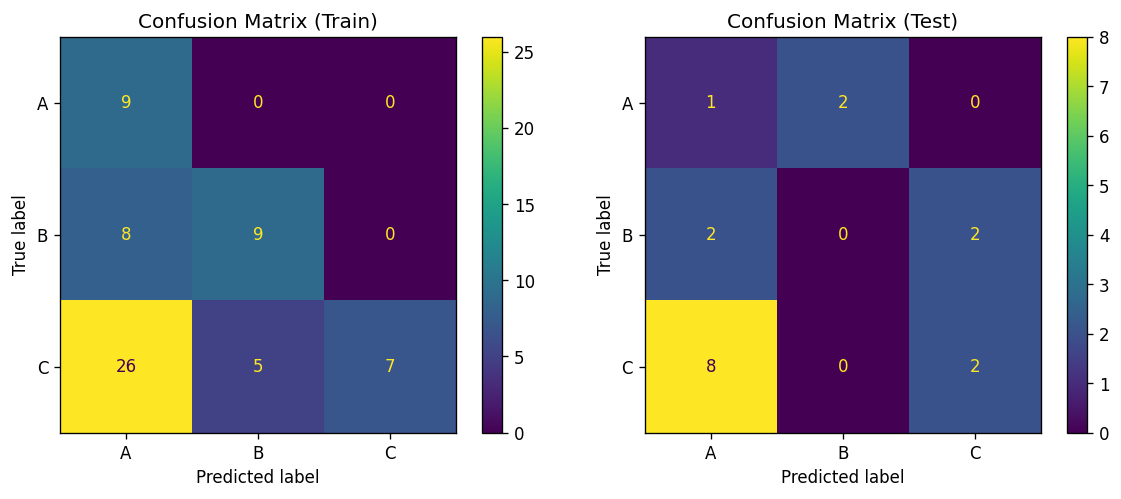

Train:
               precision    recall  f1-score   support

           A       0.21      1.00      0.35         9
           B       0.64      0.53      0.58        17
           C       1.00      0.18      0.31        38

    accuracy                           0.39        64
   macro avg       0.62      0.57      0.41        64
weighted avg       0.79      0.39      0.39        64

Test:
               precision    recall  f1-score   support

           A       0.09      0.33      0.14         3
           B       0.00      0.00      0.00         4
           C       0.50      0.20      0.29        10

    accuracy                           0.18        17
   macro avg       0.20      0.18      0.14        17
weighted avg       0.31      0.18      0.19        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.37083301 0.40728004 0.48083406 0.49690765 0.55132977 0.55132977
 0.47197224 0.47197224 0.44266821 0.44266821        nan        nan]
  warnings.warn(


KNeighborsClassifier



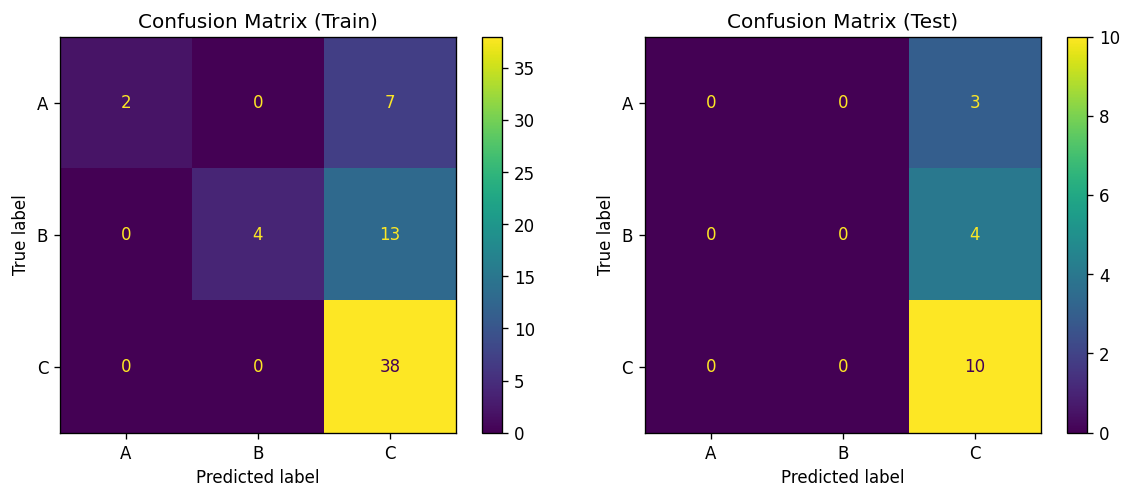

Train:
               precision    recall  f1-score   support

           A       1.00      0.22      0.36         9
           B       1.00      0.24      0.38        17
           C       0.66      1.00      0.79        38

    accuracy                           0.69        64
   macro avg       0.89      0.49      0.51        64
weighted avg       0.80      0.69      0.62        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.59      1.00      0.74        10

    accuracy                           0.59        17
   macro avg       0.20      0.33      0.25        17
weighted avg       0.35      0.59      0.44        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

SupportVectorMachine



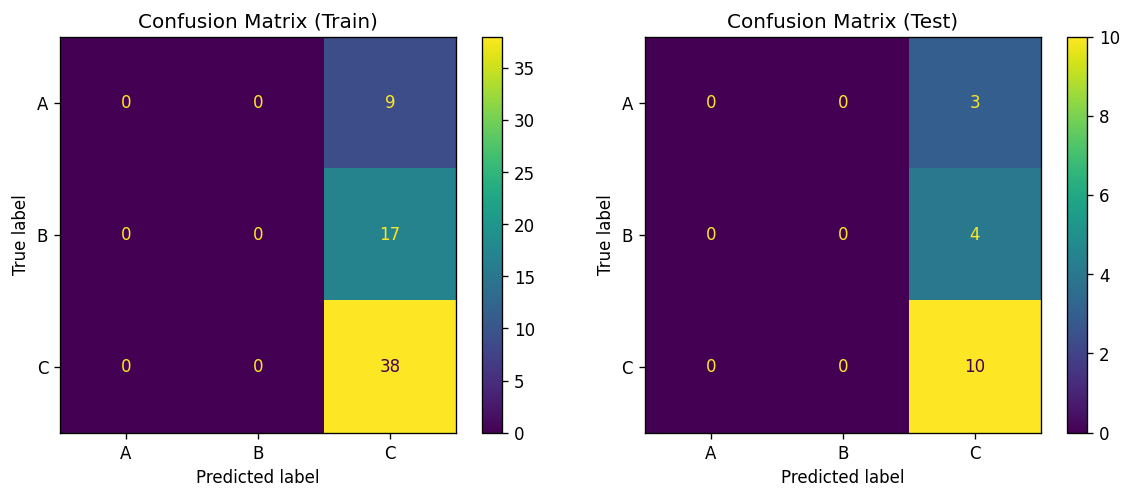

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         9
           B       0.00      0.00      0.00        17
           C       0.59      1.00      0.75        38

    accuracy                           0.59        64
   macro avg       0.20      0.33      0.25        64
weighted avg       0.35      0.59      0.44        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.59      1.00      0.74        10

    accuracy                           0.59        17
   macro avg       0.20      0.33      0.25        17
weighted avg       0.35      0.59      0.44        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

LogisticRegression



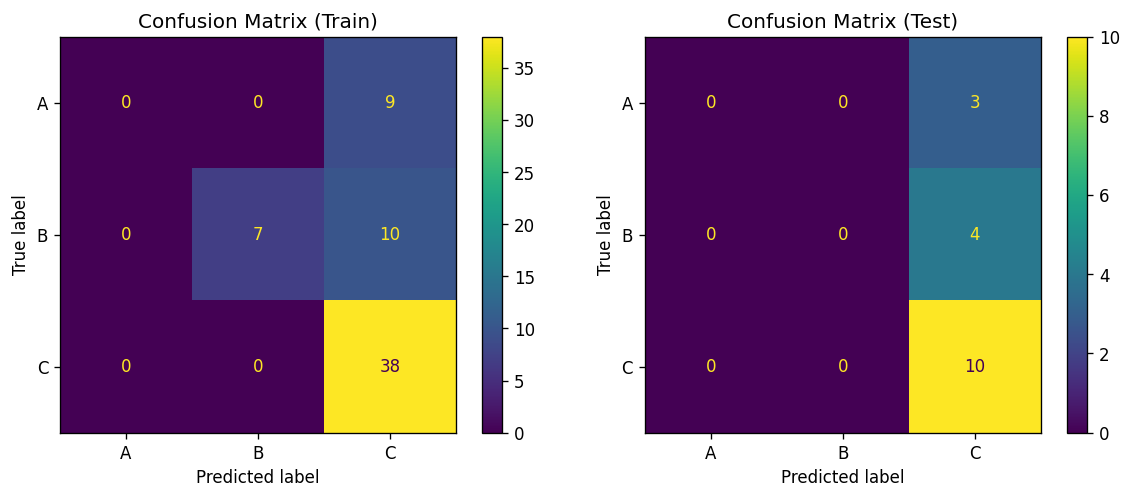

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         9
           B       1.00      0.41      0.58        17
           C       0.67      1.00      0.80        38

    accuracy                           0.70        64
   macro avg       0.56      0.47      0.46        64
weighted avg       0.66      0.70      0.63        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.59      1.00      0.74        10

    accuracy                           0.59        17
   macro avg       0.20      0.33      0.25        17
weighted avg       0.35      0.59      0.44        17

---------------------------------------------------------

---------------------------------------------------------

DecisionTreeClassifier



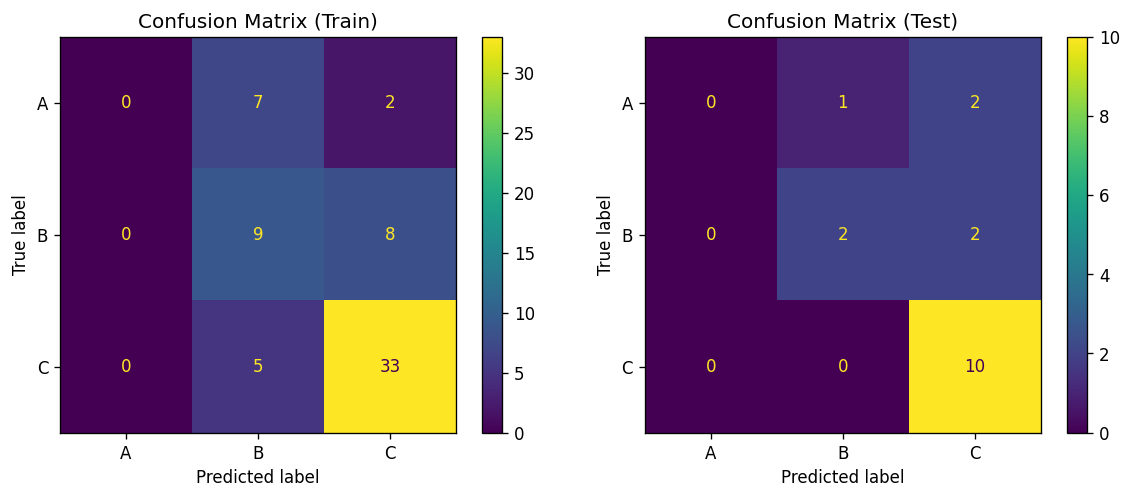

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         9
           B       0.43      0.53      0.47        17
           C       0.77      0.87      0.81        38

    accuracy                           0.66        64
   macro avg       0.40      0.47      0.43        64
weighted avg       0.57      0.66      0.61        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.67      0.50      0.57         4
           C       0.71      1.00      0.83        10

    accuracy                           0.71        17
   macro avg       0.46      0.50      0.47        17
weighted avg       0.58      0.71      0.62        17

---------------------------------------------------------

---------------------------------------------------------

ExtraTreesClassifier



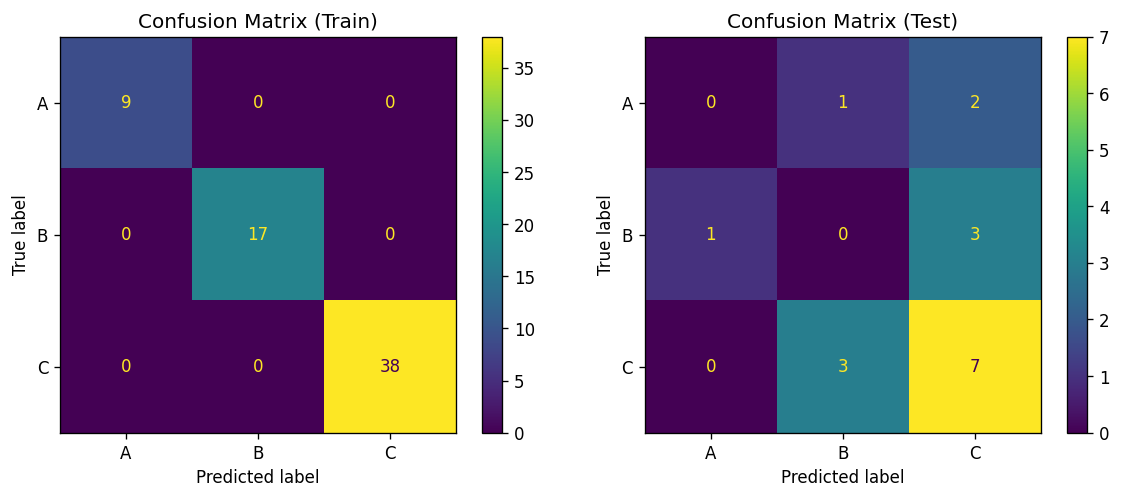

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         9
           B       1.00      1.00      1.00        17
           C       1.00      1.00      1.00        38

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.58      0.70      0.64        10

    accuracy                           0.41        17
   macro avg       0.19      0.23      0.21        17
weighted avg       0.34      0.41      0.37        17

---------------------------------------------------------

---------------------------------------------------------

RandomForestClassifier



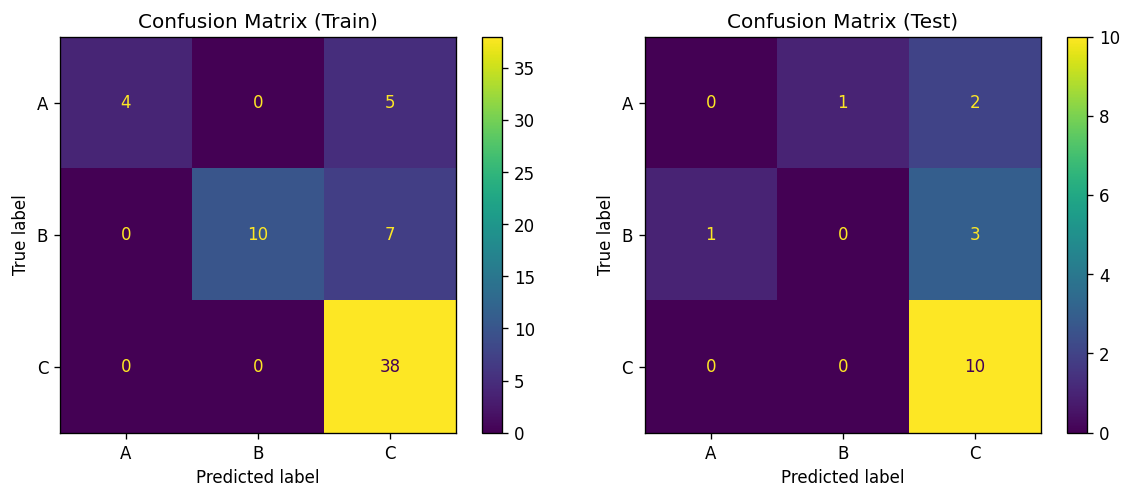

Train:
               precision    recall  f1-score   support

           A       1.00      0.44      0.62         9
           B       1.00      0.59      0.74        17
           C       0.76      1.00      0.86        38

    accuracy                           0.81        64
   macro avg       0.92      0.68      0.74        64
weighted avg       0.86      0.81      0.80        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.67      1.00      0.80        10

    accuracy                           0.59        17
   macro avg       0.22      0.33      0.27        17
weighted avg       0.39      0.59      0.47        17

---------------------------------------------------------

---------------------------------------------------------

GradientBoostingClassifier



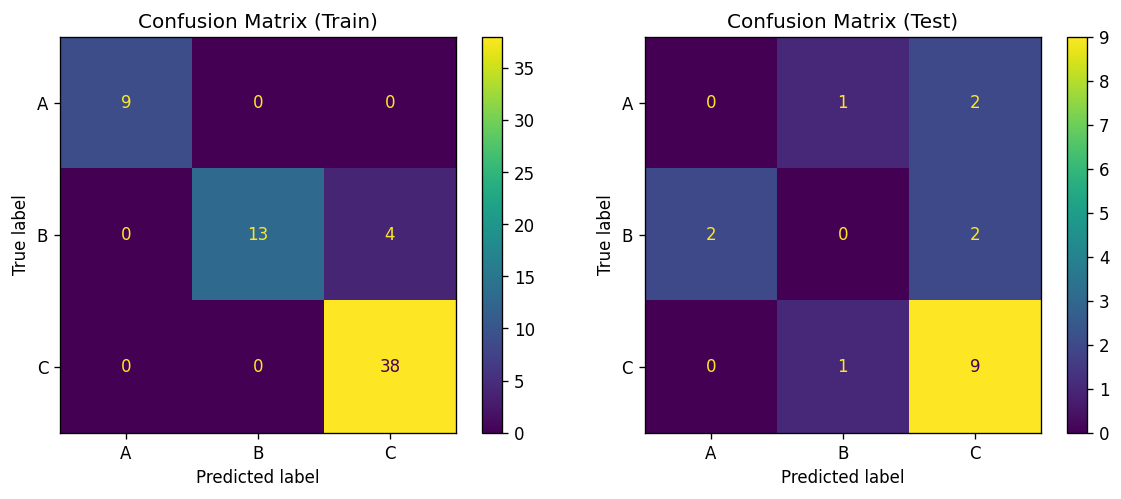

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         9
           B       1.00      0.76      0.87        17
           C       0.90      1.00      0.95        38

    accuracy                           0.94        64
   macro avg       0.97      0.92      0.94        64
weighted avg       0.94      0.94      0.93        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         4
           C       0.69      0.90      0.78        10

    accuracy                           0.53        17
   macro avg       0.23      0.30      0.26        17
weighted avg       0.41      0.53      0.46        17

---------------------------------------------------------

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.79693,0.39062,0.79394,0.39062,0.38763
1,GaussianNaiveBayes,Test,0.46719,0.17647,0.31016,0.17647,0.19328
2,KNeighborsClassifier,Train,0.74546,0.68750,0.79526,0.68750,0.62238
3,KNeighborsClassifier,Test,0.66435,0.58824,0.34602,0.58824,0.43573
4,SupportVectorMachine,Train,0.46511,0.59375,0.35254,0.59375,0.44240
5,SupportVectorMachine,Test,0.54783,0.58824,0.34602,0.58824,0.43573
6,LogisticRegression,Train,0.78946,0.70312,0.66146,0.70312,0.62995
7,LogisticRegression,Test,0.51164,0.58824,0.34602,0.58824,0.43573
8,DecisionTreeClassifier,Train,0.71682,0.65625,0.56951,0.65625,0.60962
9,DecisionTreeClassifier,Test,0.69263,0.70588,0.57703,0.70588,0.62465


,company,E-рейтинг,Prediction(E-рейтинг),Probability(E-рейтинг)=A,Probability(E-рейтинг)=B,Probability(E-рейтинг)=C
13,«Аэрофлот - Российские авиалинии»,B,B,0.333333,0.428571,0.238095
38,"«Роснефть», нефтяная компания",A,B,0.333333,0.428571,0.238095
120,ТМК (Трубная металлургическая компания),C,C,0.046512,0.186047,0.767442
113,СУЭК,C,C,0.046512,0.186047,0.767442
99,ПАО «Селигдар»,C,C,0.046512,0.186047,0.767442
45,"«Славнефть», группа",C,C,0.046512,0.186047,0.767442
8,Positive Technologies,C,C,0.046512,0.186047,0.767442
6,Globaltrans,C,C,0.046512,0.186047,0.767442
11,VK,B,C,0.046512,0.186047,0.767442
20,«Иркутская нефтяная компания»,C,C,0.046512,0.186047,0.767442


Best model is DecisionTreeClassifier

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Test,0.69263,0.70588,0.57703,0.70588,0.62465


In [ ]:
model = rating_band_prediction(train, "E-рейтинг")

S-рейтинг prediction

---------------------------------------------------------

GaussianNaiveBayes



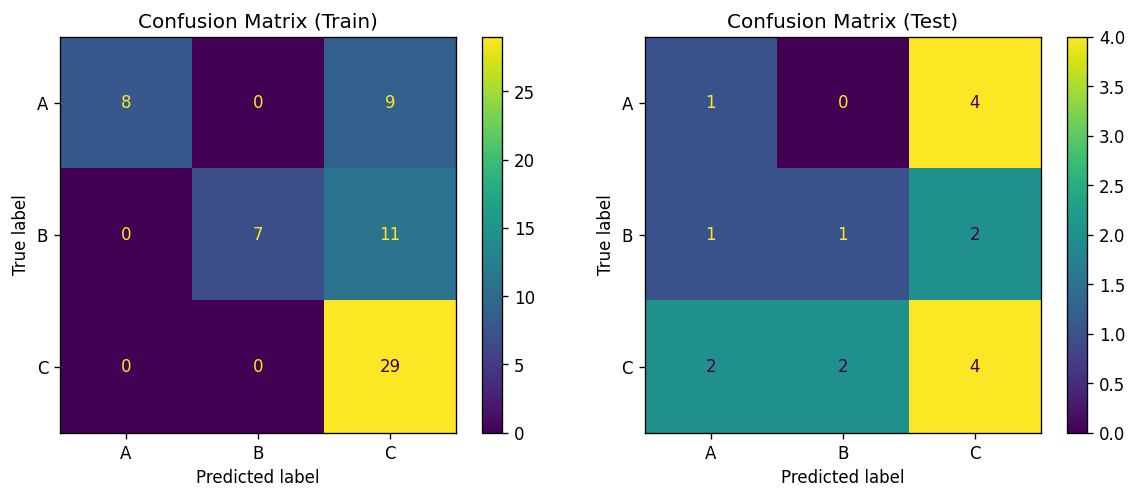

Train:
               precision    recall  f1-score   support

           A       1.00      0.47      0.64        17
           B       1.00      0.39      0.56        18
           C       0.59      1.00      0.74        29

    accuracy                           0.69        64
   macro avg       0.86      0.62      0.65        64
weighted avg       0.82      0.69      0.66        64

Test:
               precision    recall  f1-score   support

           A       0.25      0.20      0.22         5
           B       0.33      0.25      0.29         4
           C       0.40      0.50      0.44         8

    accuracy                           0.35        17
   macro avg       0.33      0.32      0.32        17
weighted avg       0.34      0.35      0.34        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.38494283 0.35869963 0.39013431 0.34750916 0.31827131 0.34263029
 0.33042629 0.30988331 0.28221799 0.28869572        nan        nan]
  warnings.warn(


KNeighborsClassifier



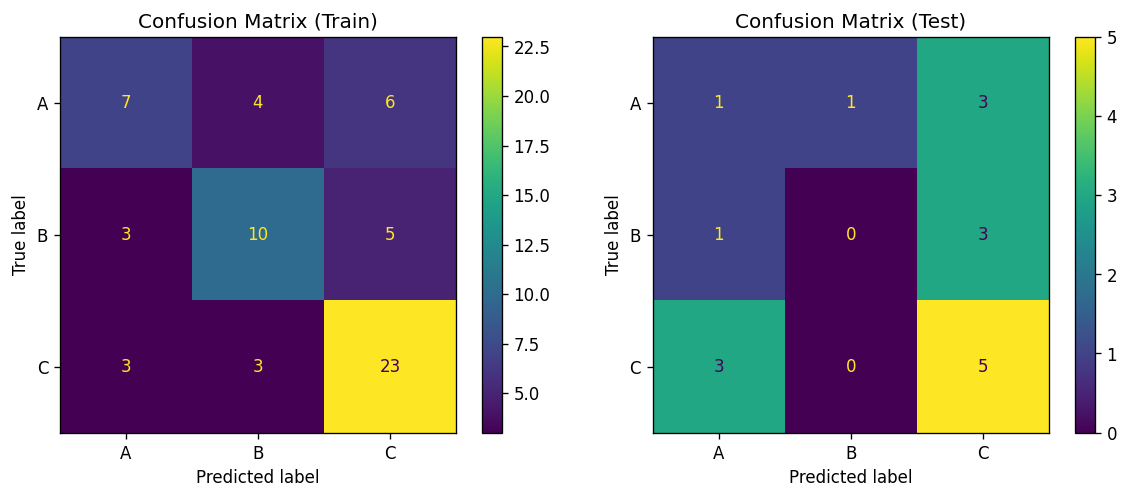

Train:
               precision    recall  f1-score   support

           A       0.54      0.41      0.47        17
           B       0.59      0.56      0.57        18
           C       0.68      0.79      0.73        29

    accuracy                           0.62        64
   macro avg       0.60      0.59      0.59        64
weighted avg       0.61      0.62      0.62        64

Test:
               precision    recall  f1-score   support

           A       0.20      0.20      0.20         5
           B       0.00      0.00      0.00         4
           C       0.45      0.62      0.53         8

    accuracy                           0.35        17
   macro avg       0.22      0.27      0.24        17
weighted avg       0.27      0.35      0.31        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3

SupportVectorMachine



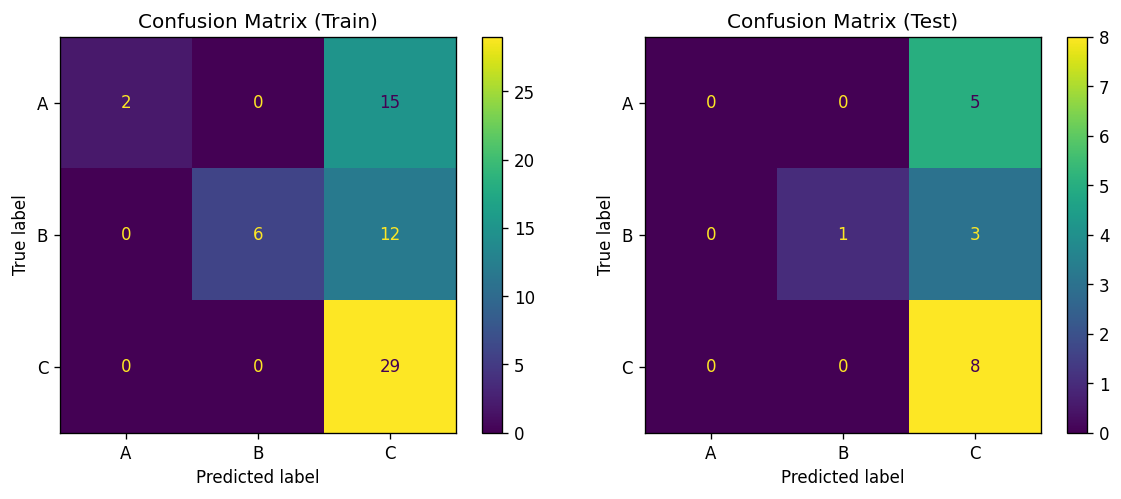

Train:
               precision    recall  f1-score   support

           A       1.00      0.12      0.21        17
           B       1.00      0.33      0.50        18
           C       0.52      1.00      0.68        29

    accuracy                           0.58        64
   macro avg       0.84      0.48      0.46        64
weighted avg       0.78      0.58      0.51        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       1.00      0.25      0.40         4
           C       0.50      1.00      0.67         8

    accuracy                           0.53        17
   macro avg       0.50      0.42      0.36        17
weighted avg       0.47      0.53      0.41        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

LogisticRegression



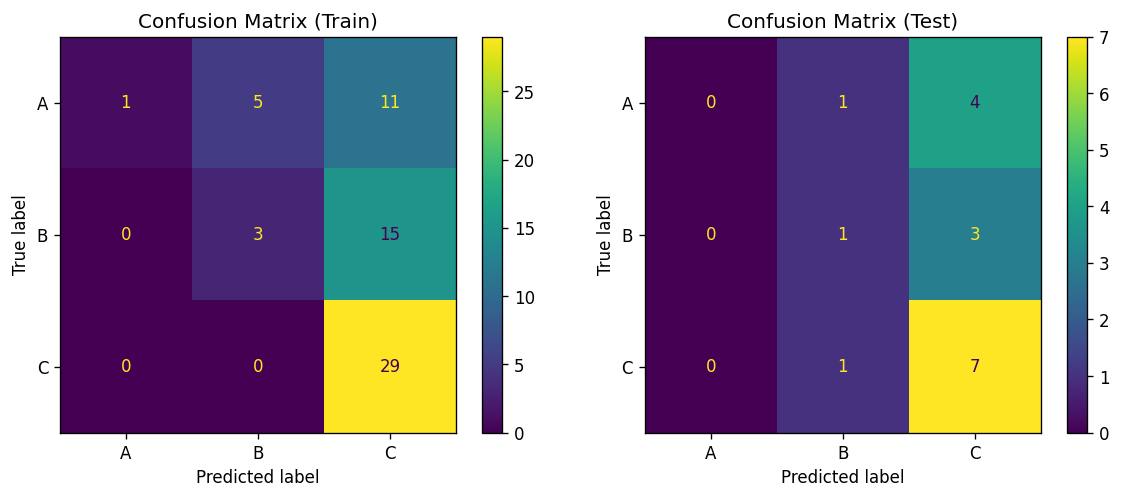

Train:
               precision    recall  f1-score   support

           A       1.00      0.06      0.11        17
           B       0.38      0.17      0.23        18
           C       0.53      1.00      0.69        29

    accuracy                           0.52        64
   macro avg       0.63      0.41      0.34        64
weighted avg       0.61      0.52      0.41        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.33      0.25      0.29         4
           C       0.50      0.88      0.64         8

    accuracy                           0.47        17
   macro avg       0.28      0.38      0.31        17
weighted avg       0.31      0.47      0.37        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

DecisionTreeClassifier



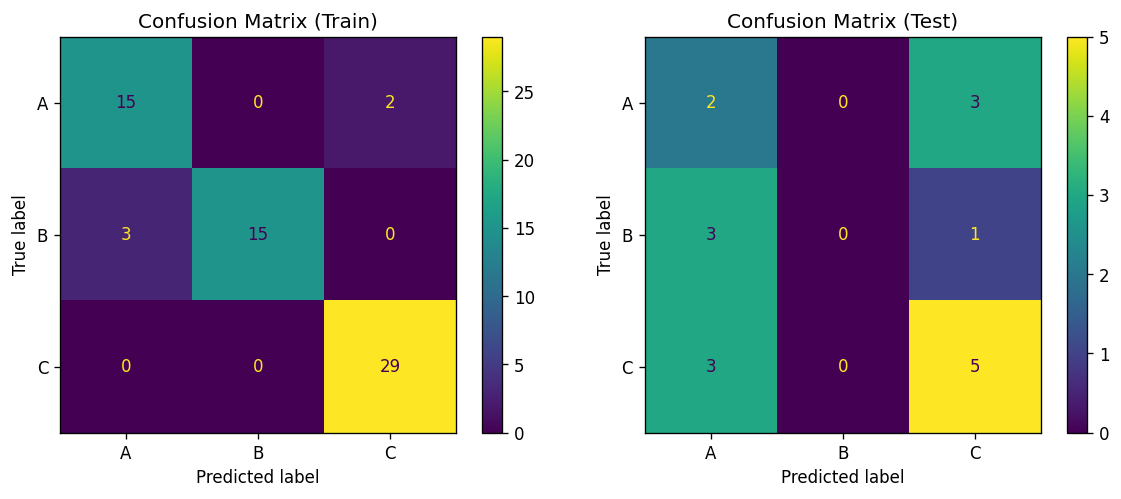

Train:
               precision    recall  f1-score   support

           A       0.83      0.88      0.86        17
           B       1.00      0.83      0.91        18
           C       0.94      1.00      0.97        29

    accuracy                           0.92        64
   macro avg       0.92      0.91      0.91        64
weighted avg       0.93      0.92      0.92        64

Test:
               precision    recall  f1-score   support

           A       0.25      0.40      0.31         5
           B       0.00      0.00      0.00         4
           C       0.56      0.62      0.59         8

    accuracy                           0.41        17
   macro avg       0.27      0.34      0.30        17
weighted avg       0.33      0.41      0.37        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

ExtraTreesClassifier



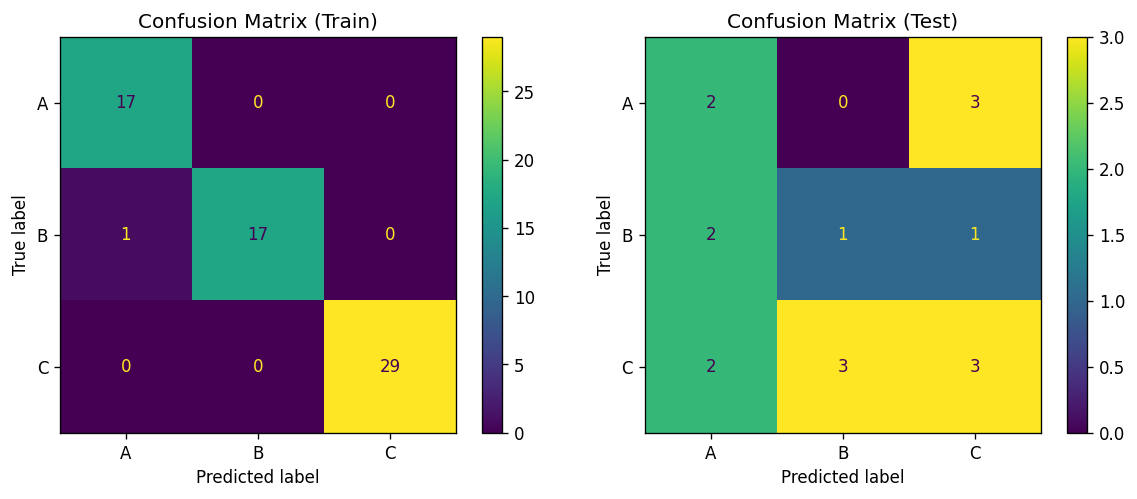

Train:
               precision    recall  f1-score   support

           A       0.94      1.00      0.97        17
           B       1.00      0.94      0.97        18
           C       1.00      1.00      1.00        29

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64

Test:
               precision    recall  f1-score   support

           A       0.33      0.40      0.36         5
           B       0.25      0.25      0.25         4
           C       0.43      0.38      0.40         8

    accuracy                           0.35        17
   macro avg       0.34      0.34      0.34        17
weighted avg       0.36      0.35      0.35        17

---------------------------------------------------------

---------------------------------------------------------

RandomForestClassifier



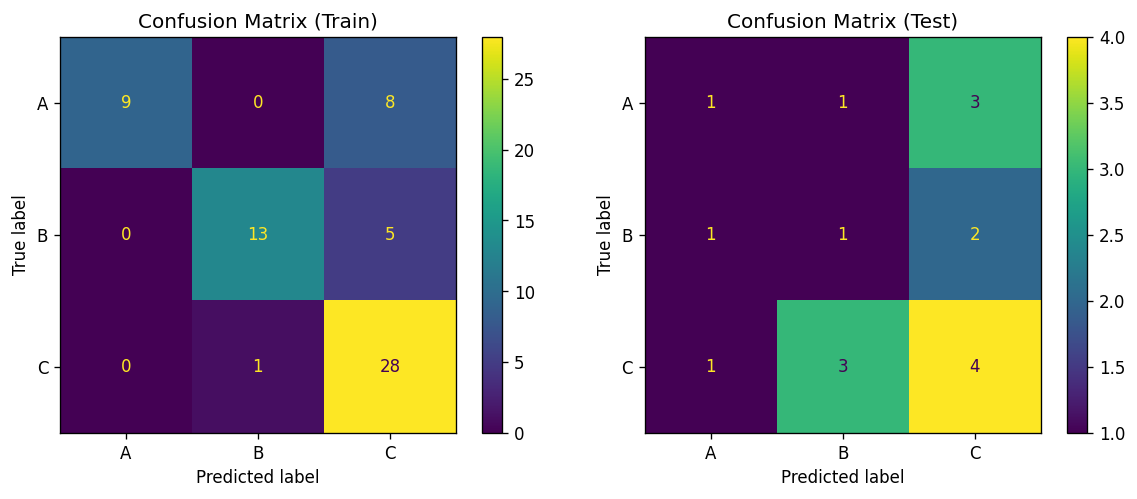

Train:
               precision    recall  f1-score   support

           A       1.00      0.53      0.69        17
           B       0.93      0.72      0.81        18
           C       0.68      0.97      0.80        29

    accuracy                           0.78        64
   macro avg       0.87      0.74      0.77        64
weighted avg       0.84      0.78      0.77        64

Test:
               precision    recall  f1-score   support

           A       0.33      0.20      0.25         5
           B       0.20      0.25      0.22         4
           C       0.44      0.50      0.47         8

    accuracy                           0.35        17
   macro avg       0.33      0.32      0.31        17
weighted avg       0.35      0.35      0.35        17

---------------------------------------------------------

---------------------------------------------------------

GradientBoostingClassifier



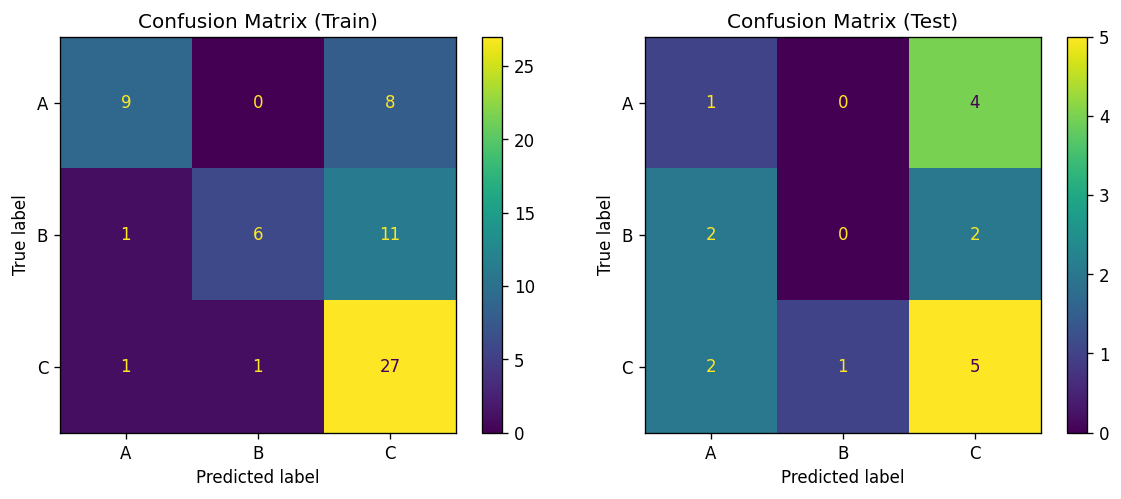

Train:
               precision    recall  f1-score   support

           A       0.82      0.53      0.64        17
           B       0.86      0.33      0.48        18
           C       0.59      0.93      0.72        29

    accuracy                           0.66        64
   macro avg       0.75      0.60      0.61        64
weighted avg       0.72      0.66      0.63        64

Test:
               precision    recall  f1-score   support

           A       0.20      0.20      0.20         5
           B       0.00      0.00      0.00         4
           C       0.45      0.62      0.53         8

    accuracy                           0.35        17
   macro avg       0.22      0.27      0.24        17
weighted avg       0.27      0.35      0.31        17

---------------------------------------------------------

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.77248,0.68750,0.81505,0.68750,0.66444
1,GaussianNaiveBayes,Test,0.48039,0.35294,0.34020,0.35294,0.34174
2,KNeighborsClassifier,Train,0.77642,0.62500,0.61500,0.62500,0.61553
3,KNeighborsClassifier,Test,0.61683,0.35294,0.27273,0.35294,0.30650
4,SupportVectorMachine,Train,0.85699,0.57812,0.78153,0.57812,0.50574
5,SupportVectorMachine,Test,0.40856,0.52941,0.47059,0.52941,0.40784
6,LogisticRegression,Train,0.72893,0.51562,0.61001,0.51562,0.40729
7,LogisticRegression,Test,0.51452,0.47059,0.31373,0.47059,0.36669
8,DecisionTreeClassifier,Train,0.98107,0.92188,0.92650,0.92188,0.92138
9,DecisionTreeClassifier,Test,0.54405,0.41176,0.33497,0.41176,0.36731


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3

,company,S-рейтинг,Prediction(S-рейтинг),Probability(S-рейтинг)=A,Probability(S-рейтинг)=B,Probability(S-рейтинг)=C
40,«РусГидро»,B,B,0.238386,0.435028,0.326586
35,«Полиметалл»,A,C,0.249800,0.260625,0.489574
8,Positive Technologies,C,C,0.226049,0.365707,0.408244
70,Банк «Санкт-Петербург»,C,C,0.248555,0.261486,0.489959
23,«Квадра»,C,C,0.250624,0.260285,0.489091
58,«Яндекс»,B,C,0.345315,0.261851,0.392833
120,ТМК (Трубная металлургическая компания),B,C,0.246275,0.261264,0.492462
41,"«Русагро», группа компаний",C,C,0.286590,0.169688,0.543722
92,Магнитогорский металлургический комбинат (ММК),A,C,0.248470,0.259933,0.491597
2,"""Черкизово""",C,C,0.262443,0.256542,0.481015


Best model is SupportVectorMachine

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,SupportVectorMachine,Test,0.40856,0.52941,0.47059,0.52941,0.40784


In [ ]:
model2 = rating_band_prediction(train, "S-рейтинг")

G-рейтинг prediction

---------------------------------------------------------

GaussianNaiveBayes



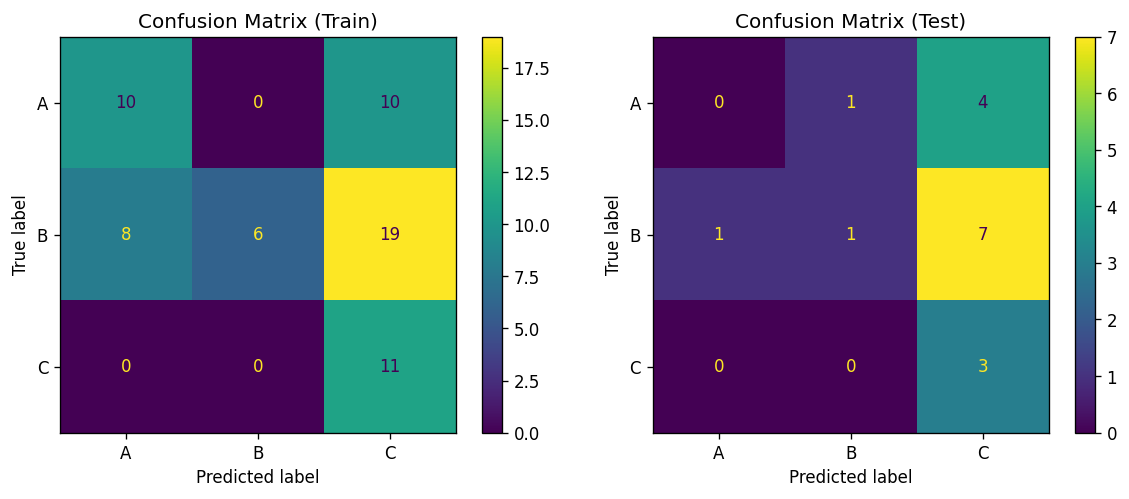

Train:
               precision    recall  f1-score   support

           A       0.56      0.50      0.53        20
           B       1.00      0.18      0.31        33
           C       0.28      1.00      0.43        11

    accuracy                           0.42        64
   macro avg       0.61      0.56      0.42        64
weighted avg       0.74      0.42      0.40        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.50      0.11      0.18         9
           C       0.21      1.00      0.35         3

    accuracy                           0.24        17
   macro avg       0.24      0.37      0.18        17
weighted avg       0.30      0.24      0.16        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.38128773 0.35188978 0.31448107 0.33514652 0.37630229 0.35447964
 0.35112011 0.32901484 0.35112011 0.33638327        nan        nan]
  warnings.warn(


KNeighborsClassifier



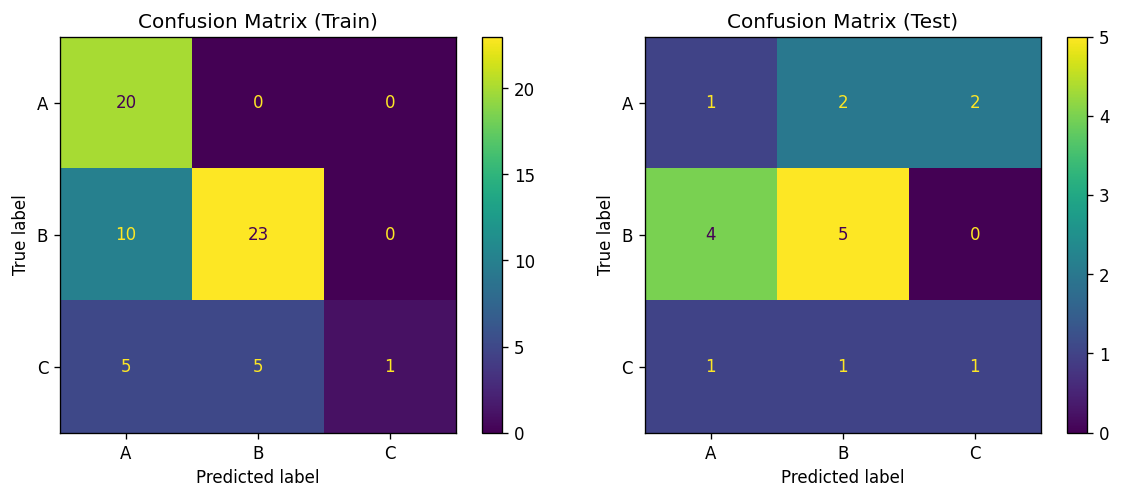

Train:
               precision    recall  f1-score   support

           A       0.57      1.00      0.73        20
           B       0.82      0.70      0.75        33
           C       1.00      0.09      0.17        11

    accuracy                           0.69        64
   macro avg       0.80      0.60      0.55        64
weighted avg       0.77      0.69      0.64        64

Test:
               precision    recall  f1-score   support

           A       0.17      0.20      0.18         5
           B       0.62      0.56      0.59         9
           C       0.33      0.33      0.33         3

    accuracy                           0.41        17
   macro avg       0.38      0.36      0.37        17
weighted avg       0.44      0.41      0.42        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3

SupportVectorMachine



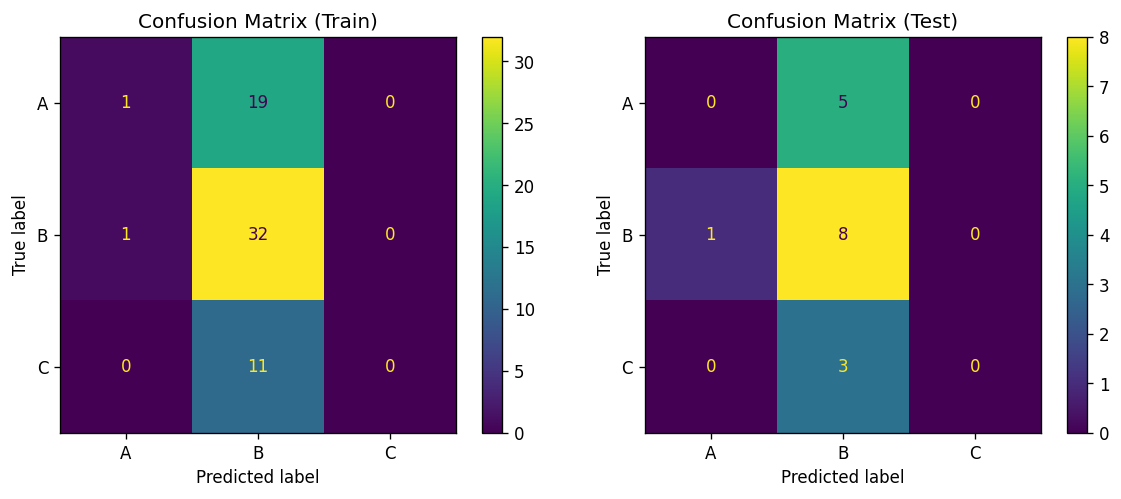

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.50      0.05      0.09        20
           B       0.52      0.97      0.67        33
           C       0.00      0.00      0.00        11

    accuracy                           0.52        64
   macro avg       0.34      0.34      0.25        64
weighted avg       0.42      0.52      0.38        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.50      0.89      0.64         9
           C       0.00      0.00      0.00         3

    accuracy                           0.47        17
   macro avg       0.17      0.30      0.21        17
weighted avg       0.26      0.47      0.34        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

LogisticRegression



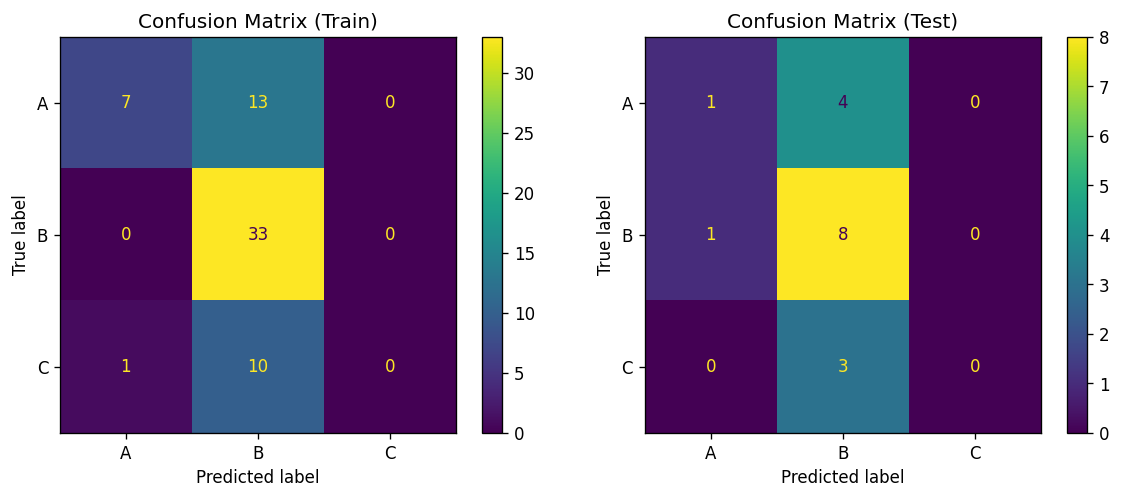

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.88      0.35      0.50        20
           B       0.59      1.00      0.74        33
           C       0.00      0.00      0.00        11

    accuracy                           0.62        64
   macro avg       0.49      0.45      0.41        64
weighted avg       0.58      0.62      0.54        64

Test:
               precision    recall  f1-score   support

           A       0.50      0.20      0.29         5
           B       0.53      0.89      0.67         9
           C       0.00      0.00      0.00         3

    accuracy                           0.53        17
   macro avg       0.34      0.36      0.32        17
weighted avg       0.43      0.53      0.44        17

---------------------------------------------------------

---------------------------------------------------------

DecisionTreeClassifier



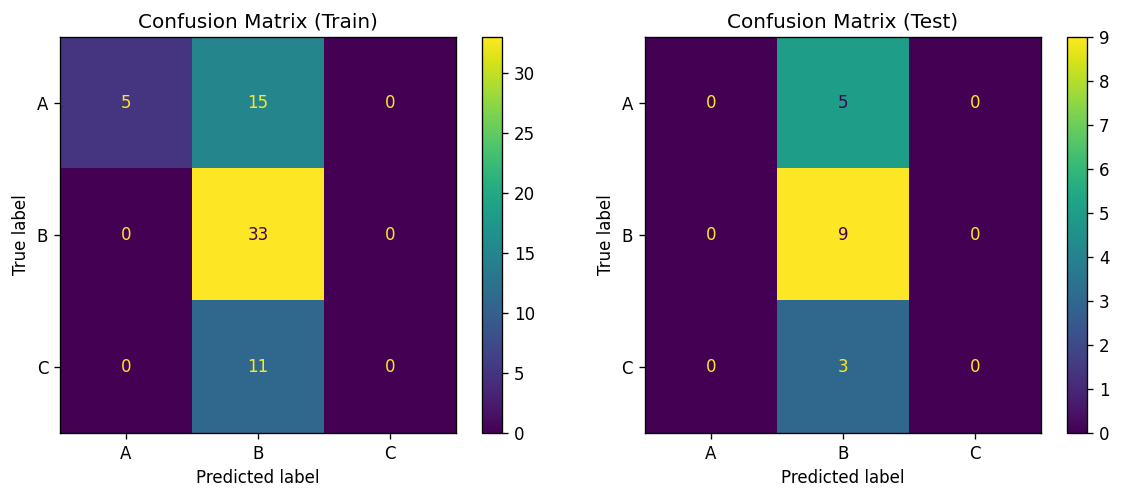

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       1.00      0.25      0.40        20
           B       0.56      1.00      0.72        33
           C       0.00      0.00      0.00        11

    accuracy                           0.59        64
   macro avg       0.52      0.42      0.37        64
weighted avg       0.60      0.59      0.49        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.53      1.00      0.69         9
           C       0.00      0.00      0.00         3

    accuracy                           0.53        17
   macro avg       0.18      0.33      0.23        17
weighted avg       0.28      0.53      0.37        17

---------------------------------------------------------

---------------------------------------------------------

ExtraTreesClassifier



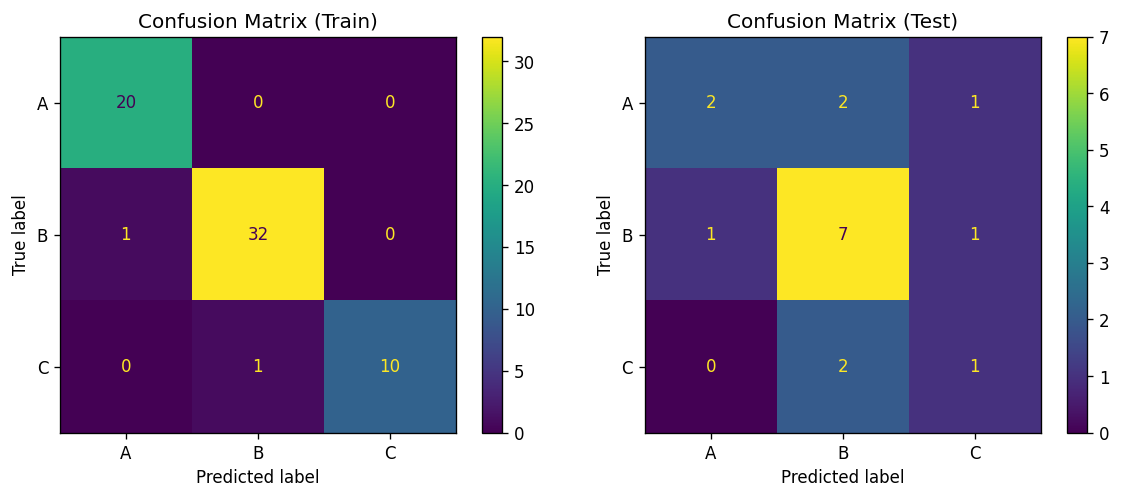

Train:
               precision    recall  f1-score   support

           A       0.95      1.00      0.98        20
           B       0.97      0.97      0.97        33
           C       1.00      0.91      0.95        11

    accuracy                           0.97        64
   macro avg       0.97      0.96      0.97        64
weighted avg       0.97      0.97      0.97        64

Test:
               precision    recall  f1-score   support

           A       0.67      0.40      0.50         5
           B       0.64      0.78      0.70         9
           C       0.33      0.33      0.33         3

    accuracy                           0.59        17
   macro avg       0.55      0.50      0.51        17
weighted avg       0.59      0.59      0.58        17

---------------------------------------------------------

---------------------------------------------------------

RandomForestClassifier



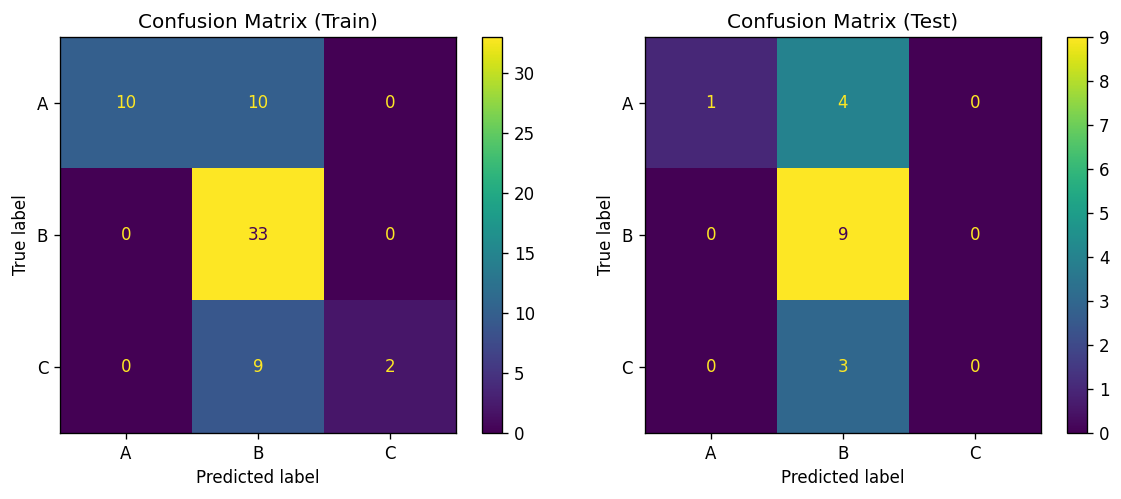

Train:
               precision    recall  f1-score   support

           A       1.00      0.50      0.67        20
           B       0.63      1.00      0.78        33
           C       1.00      0.18      0.31        11

    accuracy                           0.70        64
   macro avg       0.88      0.56      0.58        64
weighted avg       0.81      0.70      0.66        64

Test:
               precision    recall  f1-score   support

           A       1.00      0.20      0.33         5
           B       0.56      1.00      0.72         9
           C       0.00      0.00      0.00         3

    accuracy                           0.59        17
   macro avg       0.52      0.40      0.35        17
weighted avg       0.59      0.59      0.48        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

GradientBoostingClassifier



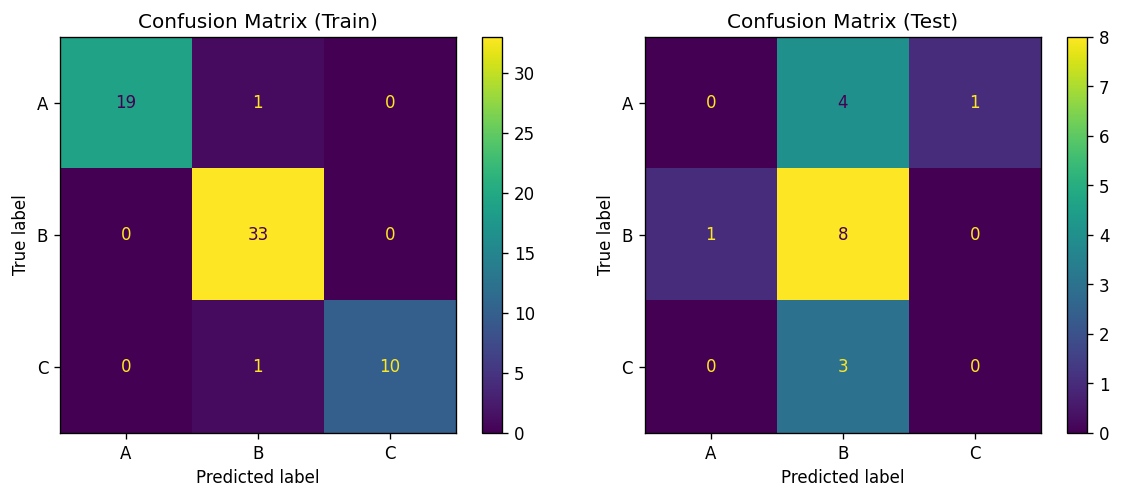

Train:
               precision    recall  f1-score   support

           A       1.00      0.95      0.97        20
           B       0.94      1.00      0.97        33
           C       1.00      0.91      0.95        11

    accuracy                           0.97        64
   macro avg       0.98      0.95      0.97        64
weighted avg       0.97      0.97      0.97        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.53      0.89      0.67         9
           C       0.00      0.00      0.00         3

    accuracy                           0.47        17
   macro avg       0.18      0.30      0.22        17
weighted avg       0.28      0.47      0.35        17

---------------------------------------------------------

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.75099,0.42188,0.73650,0.42188,0.39727
1,GaussianNaiveBayes,Test,0.59121,0.23529,0.30252,0.23529,0.15854
2,KNeighborsClassifier,Train,0.88079,0.68750,0.77400,0.68750,0.64475
3,KNeighborsClassifier,Test,0.54412,0.41176,0.43873,0.41176,0.42372
4,SupportVectorMachine,Train,0.32625,0.51562,0.42238,0.51562,0.37578
5,SupportVectorMachine,Test,0.37885,0.47059,0.26471,0.47059,0.33882
6,LogisticRegression,Train,0.69081,0.62500,0.57729,0.62500,0.53862
7,LogisticRegression,Test,0.54447,0.52941,0.42941,0.52941,0.43697
8,DecisionTreeClassifier,Train,0.58875,0.59375,0.60090,0.59375,0.49490
9,DecisionTreeClassifier,Test,0.50000,0.52941,0.28028,0.52941,0.36652


,company,G-рейтинг,Prediction(G-рейтинг),Probability(G-рейтинг)=A,Probability(G-рейтинг)=B,Probability(G-рейтинг)=C
16,«Группа Черкизово»,B,B,0.28,0.68,0.04
40,«РусГидро»,A,B,0.32,0.60,0.08
9,S7 Airlines,C,C,0.10,0.37,0.53
79,Газпромбанк,C,B,0.16,0.76,0.08
28,"«М.Видео-Эльдорадо», группа",B,B,0.34,0.62,0.04
37,«Росатом»,B,B,0.16,0.55,0.29
33,«Объединенная авиастроительная корпорация»,B,C,0.13,0.22,0.65
100,ПАО КБ «‎Центр-Инвест»,C,B,0.30,0.54,0.16
32,"«Норильский никель», горно-металлургическая ко...",A,A,0.38,0.36,0.26
62,АФК «Система»,B,B,0.18,0.76,0.06


Best model is ExtraTreesClassifier

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,ExtraTreesClassifier,Test,0.62377,0.58824,0.5918,0.58824,0.57647


In [ ]:
model3 = rating_band_prediction(train, "G-рейтинг")

ESG-рейтинг prediction

---------------------------------------------------------

GaussianNaiveBayes



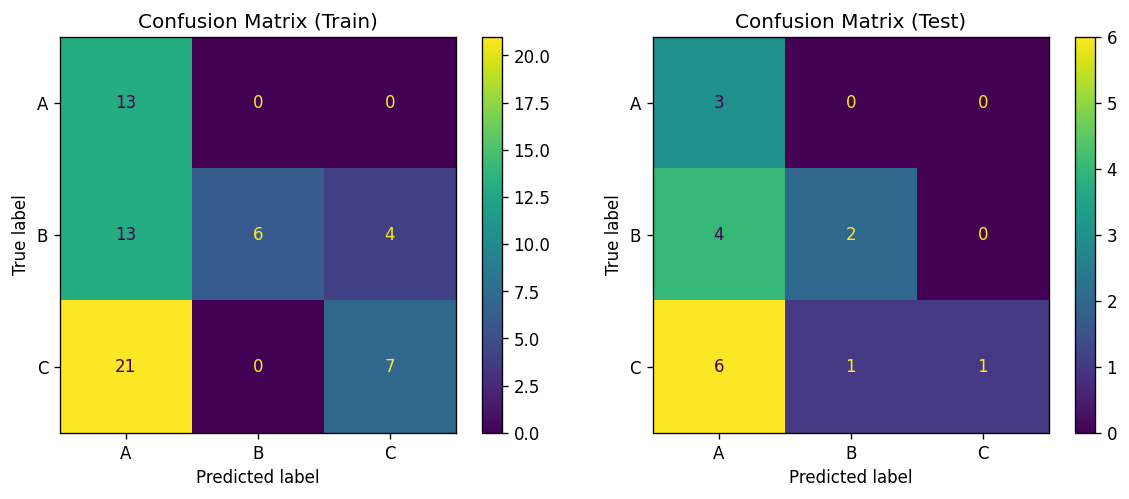

Train:
               precision    recall  f1-score   support

           A       0.28      1.00      0.43        13
           B       1.00      0.26      0.41        23
           C       0.64      0.25      0.36        28

    accuracy                           0.41        64
   macro avg       0.64      0.50      0.40        64
weighted avg       0.69      0.41      0.39        64

Test:
               precision    recall  f1-score   support

           A       0.23      1.00      0.38         3
           B       0.67      0.33      0.44         6
           C       1.00      0.12      0.22         8

    accuracy                           0.35        17
   macro avg       0.63      0.49      0.35        17
weighted avg       0.75      0.35      0.33        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.26932401 0.36293097 0.39806698 0.36200855 0.28889439 0.37704518
 0.33581468 0.36566697 0.26665344 0.31644836        nan        nan]
  warnings.warn(


KNeighborsClassifier



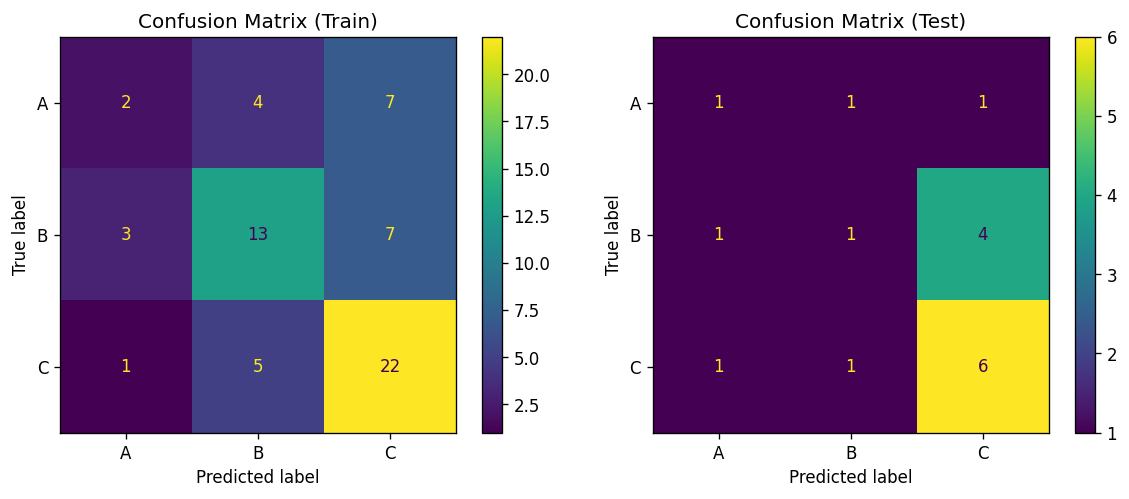

Train:
               precision    recall  f1-score   support

           A       0.33      0.15      0.21        13
           B       0.59      0.57      0.58        23
           C       0.61      0.79      0.69        28

    accuracy                           0.58        64
   macro avg       0.51      0.50      0.49        64
weighted avg       0.55      0.58      0.55        64

Test:
               precision    recall  f1-score   support

           A       0.33      0.33      0.33         3
           B       0.33      0.17      0.22         6
           C       0.55      0.75      0.63         8

    accuracy                           0.47        17
   macro avg       0.40      0.42      0.40        17
weighted avg       0.43      0.47      0.43        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3

SupportVectorMachine



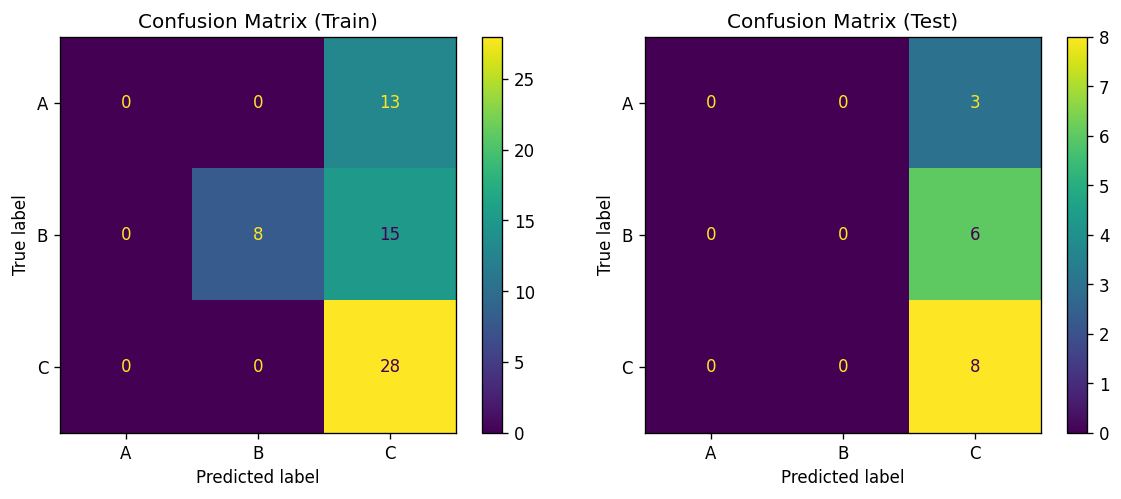

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       1.00      0.35      0.52        23
           C       0.50      1.00      0.67        28

    accuracy                           0.56        64
   macro avg       0.50      0.45      0.39        64
weighted avg       0.58      0.56      0.48        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.00      0.00      0.00         6
           C       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.16      0.33      0.21        17
weighted avg       0.22      0.47      0.30        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

LogisticRegression



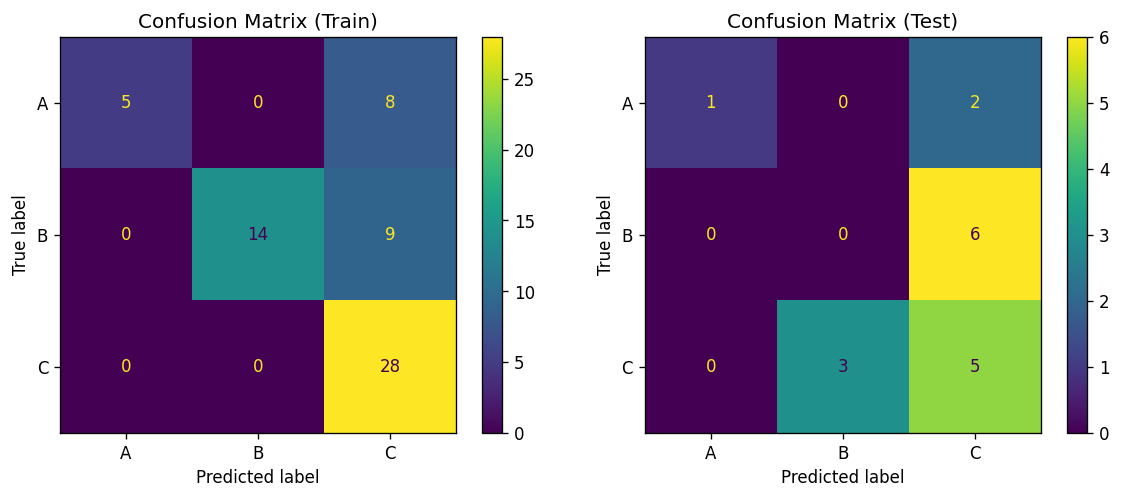

Train:
               precision    recall  f1-score   support

           A       1.00      0.38      0.56        13
           B       1.00      0.61      0.76        23
           C       0.62      1.00      0.77        28

    accuracy                           0.73        64
   macro avg       0.87      0.66      0.69        64
weighted avg       0.83      0.73      0.72        64

Test:
               precision    recall  f1-score   support

           A       1.00      0.33      0.50         3
           B       0.00      0.00      0.00         6
           C       0.38      0.62      0.48         8

    accuracy                           0.35        17
   macro avg       0.46      0.32      0.33        17
weighted avg       0.36      0.35      0.31        17

---------------------------------------------------------

---------------------------------------------------------

DecisionTreeClassifier



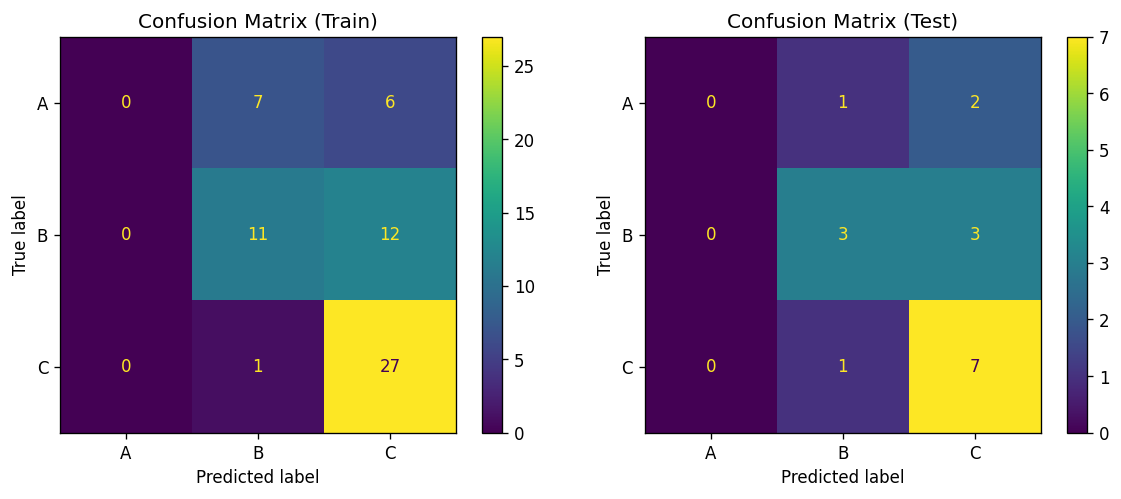

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.58      0.48      0.52        23
           C       0.60      0.96      0.74        28

    accuracy                           0.59        64
   macro avg       0.39      0.48      0.42        64
weighted avg       0.47      0.59      0.51        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.60      0.50      0.55         6
           C       0.58      0.88      0.70         8

    accuracy                           0.59        17
   macro avg       0.39      0.46      0.42        17
weighted avg       0.49      0.59      0.52        17

---------------------------------------------------------

---------------------------------------------------------

ExtraTreesClassifier



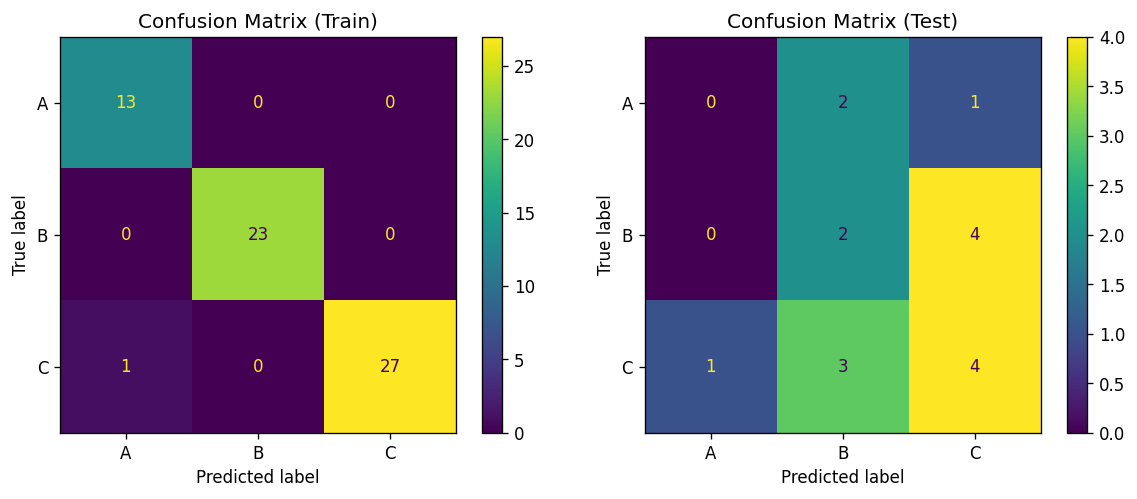

Train:
               precision    recall  f1-score   support

           A       0.93      1.00      0.96        13
           B       1.00      1.00      1.00        23
           C       1.00      0.96      0.98        28

    accuracy                           0.98        64
   macro avg       0.98      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.29      0.33      0.31         6
           C       0.44      0.50      0.47         8

    accuracy                           0.35        17
   macro avg       0.24      0.28      0.26        17
weighted avg       0.31      0.35      0.33        17

---------------------------------------------------------

---------------------------------------------------------

RandomForestClassifier



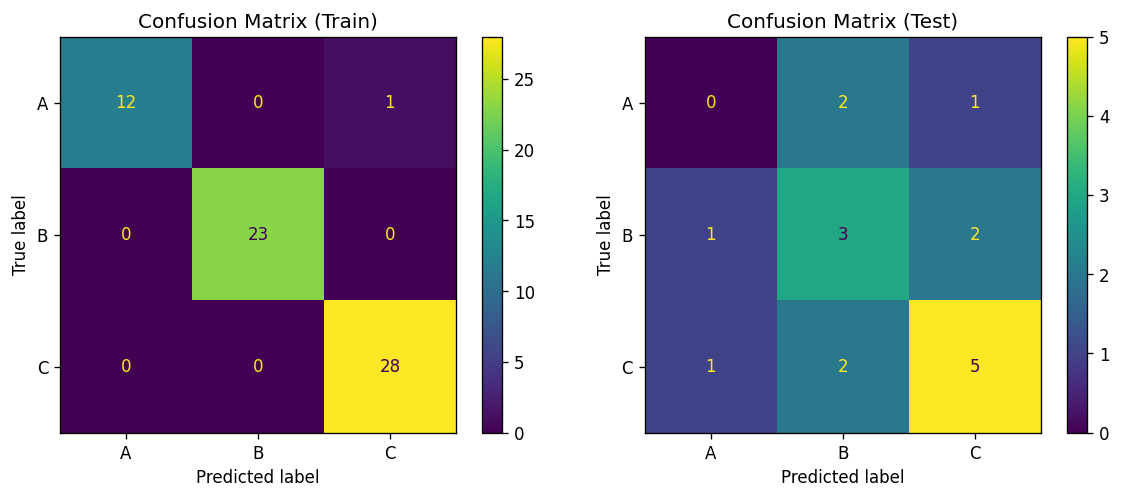

Train:
               precision    recall  f1-score   support

           A       1.00      0.92      0.96        13
           B       1.00      1.00      1.00        23
           C       0.97      1.00      0.98        28

    accuracy                           0.98        64
   macro avg       0.99      0.97      0.98        64
weighted avg       0.98      0.98      0.98        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.43      0.50      0.46         6
           C       0.62      0.62      0.62         8

    accuracy                           0.47        17
   macro avg       0.35      0.38      0.36        17
weighted avg       0.45      0.47      0.46        17

---------------------------------------------------------

---------------------------------------------------------

GradientBoostingClassifier



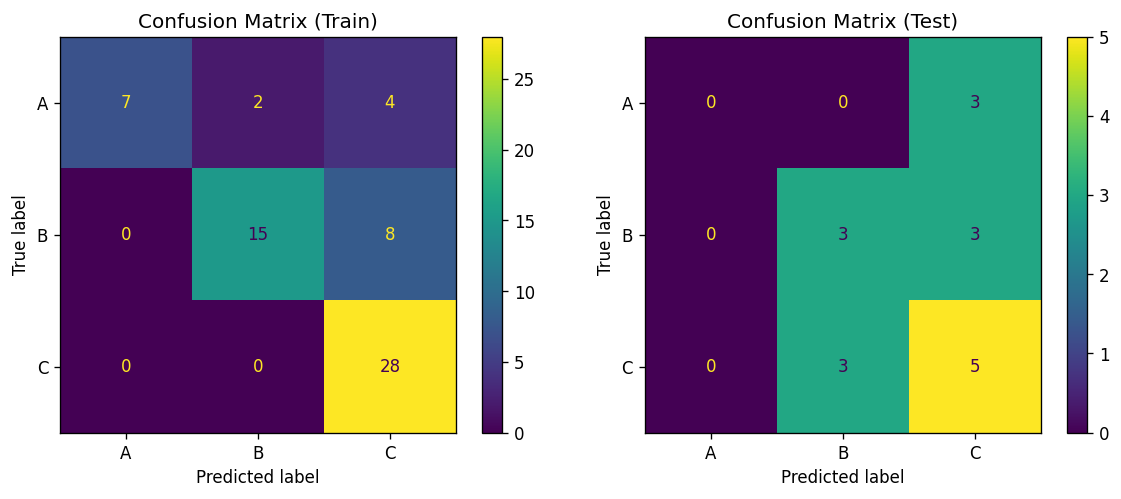

Train:
               precision    recall  f1-score   support

           A       1.00      0.54      0.70        13
           B       0.88      0.65      0.75        23
           C       0.70      1.00      0.82        28

    accuracy                           0.78        64
   macro avg       0.86      0.73      0.76        64
weighted avg       0.83      0.78      0.77        64

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.50      0.50      0.50         6
           C       0.45      0.62      0.53         8

    accuracy                           0.47        17
   macro avg       0.32      0.38      0.34        17
weighted avg       0.39      0.47      0.42        17

---------------------------------------------------------

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,GaussianNaiveBayes,Train,0.77477,0.40625,0.69397,0.40625,0.39378
1,GaussianNaiveBayes,Test,0.59354,0.35294,0.74661,0.35294,0.32761
2,KNeighborsClassifier,Train,0.77101,0.57812,0.54743,0.57812,0.55118
3,KNeighborsClassifier,Test,0.46089,0.47059,0.43316,0.47059,0.43447
4,SupportVectorMachine,Train,0.88602,0.56250,0.57812,0.56250,0.47715
5,SupportVectorMachine,Test,0.22040,0.47059,0.22145,0.47059,0.30118
6,LogisticRegression,Train,0.92839,0.73438,0.83472,0.73438,0.72042
7,LogisticRegression,Test,0.28482,0.35294,0.35747,0.35294,0.31232
8,DecisionTreeClassifier,Train,0.68323,0.59375,0.47056,0.59375,0.51187
9,DecisionTreeClassifier,Test,0.63551,0.58824,0.48627,0.58824,0.52193


,company,ESG-рейтинг,Prediction(ESG-рейтинг),Probability(ESG-рейтинг)=A,Probability(ESG-рейтинг)=B,Probability(ESG-рейтинг)=C
25,«КуйбышевАзот»,C,C,0.133333,0.266667,0.600000
43,"«РуссНефть», нефтегазовая компания",C,C,0.133333,0.266667,0.600000
35,«Полиметалл»,A,C,0.133333,0.266667,0.600000
30,«Металлоинвест»,B,C,0.133333,0.266667,0.600000
113,СУЭК,B,C,0.133333,0.266667,0.600000
75,ВТБ,C,B,0.368421,0.578947,0.052632
6,Globaltrans,B,C,0.133333,0.266667,0.600000
53,«УГМК»,C,C,0.133333,0.266667,0.600000
9,S7 Airlines,C,C,0.133333,0.266667,0.600000
89,ЛЕНТА,B,B,0.368421,0.578947,0.052632


Best model is DecisionTreeClassifier

---------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,DecisionTreeClassifier,Test,0.63551,0.58824,0.48627,0.58824,0.52193


In [ ]:
model3 = rating_band_prediction(train, "ESG-рейтинг")

In [ ]:
test1 = test.drop(['ESG-рейтинг',	'E-рейтинг',	'S-рейтинг',	'G-рейтинг'], axis = 1)

In [ ]:
result = for_pred["company"]

In [ ]:
for_pred['ESG-рейтинг']= model3.predict(for_pred)

In [ ]:
result = pd.concat([result, for_pred['ESG-рейтинг']], axis =1)

In [ ]:
result.to_csv('ratings.csv', index=False)

In [ ]:
result.loc[result.sample(frac=0.75).index, "G-рейтинг"] = "C"

In [ ]:
result

,company,E-рейтинг,S-рейтинг,G-рейтинг,ESG-рейтинг
0,"""Альфа-Банк""",C,C,C,C
1,"""Бронка Групп""",C,C,A,C
2,"""Черкизово""",C,C,B,C
3,Cosmos Hotel Group,B,C,C,B
4,En+ Group,C,C,A,C
...,...,...,...,...,...
121,Тинькофф Банк,C,C,B,C
122,УКООЛО,C,C,B,C
123,Юрент,C,C,C,C
124,“Активный компонент”,C,C,B,C


In [ ]:
companies = pd.read_excel("/content/companies/RAEX2024 (2).xlsx")
main_dataset = combined_df.reset_index()

def clean_company_name(name):
    if "Segezha Group" in name:
        return "Сегежа Групп".strip().lower()
    if "Билайн (Вымпелком СЗФО)" in name:
        return "Вымпелком".strip().lower()
    if "ПИК" in name:
        return "Группа Компаний ПИК".strip().lower()
    name = str(name)
    name = re.sub(r'\bПАО\b', '', name)
    name = re.sub(r'\bГруппа\b', '', name)
    name = re.sub(r'\bБанк\b', '', name)
    name = re.sub(r',.*$', '', name)
    name = re.sub(r'\s*\(.*?\)\s*', '', name)
    return str(name).replace('«', '').replace('»', '').replace('"', '').replace('”', '').replace('“', '').strip().lower()


main_dataset['clean_company'] = main_dataset['company'].apply(clean_company_name)

# Очистим названия компаний в Excel файле
companies['clean_company'] = companies['Название'].apply(clean_company_name)

# Шаг 3: Присоединить данные из Excel файла к основному датасету
merged_data = main_dataset.merge(companies[['clean_company', 'ESG-рейтинг', 'E-рейтинг', 'S-рейтинг', 'G-рейтинг']],
                                 how='left',
                                 on='clean_company')

# Удалим лишние колонки
merged_data.drop(columns=['clean_company'], axis=1, inplace=True)

# Вернем индексы на место
#merged_data.set_index('company', inplace=True)
merged_data = merged_data.drop(['index'], axis = 1)
merged_data

,company,0,Биоразнообразие,Вода,Воздух,Заинтересованные стороны,Закупки и антикоррупция,Инновации,Кибербезопасность,Климат,Коренные народы и местные сообщ,Корпоративное управление,Лидерство,Малый и локальный бизнес,Обучение и развитие,Оплата труда,Отношения с инвесторами,Отходы и циклическая экономика,Отчетность и прозрачность,Персонал в целом,Поставщики в целом,Поставщики. Работники,Поставщики. Экология,Потребители. Доступность,Потребители. Здоровье и благопо,Потребители. Качество и безопас,"Потребители. Маркетинг, продажи",Потребители. Персональные данны,Потребители. Сервис и коммуника,Потребители. Удовлетворенность,Потребители. Ценовая политика,Права человека,Рекультивация земель,Риски,Сотрудники. Безопасность и охра,Сотрудники. Вовлеченность и мот,Сотрудники. Волонтерство,Сотрудники. Здоровье и благопол,Сотрудники. Корпоративная культ,Сотрудники. Наем и увольнение,Сотрудники. Профсоюз и Коллекти,Социальные инвестиции и благотв,Устойчивое развитие,Экологичность продукта,Экология в целом,Энергия,Этика и антикоррупция,Климат_Окрас,Энергия_Окрас,Воздух_Окрас,Вода_Окрас,Отходы и циклическая экономика_Окрас,Биоразнообразие_Окрас,Рекультивация земель_Окрас,Экологичность продукта_Окрас,Персонал в целом_Окрас,Обучение и развитие_Окрас,Сотрудники. Вовлеченность и мот_Окрас,Оплата труда_Окрас,Сотрудники. Здоровье и благопол_Окрас,Сотрудники. Наем и увольнение_Окрас,Сотрудники. Корпоративная культ_Окрас,Сотрудники. Безопасность и охра_Окрас,Сотрудники. Профсоюз и Коллекти_Окрас,Потребители. Доступность_Окрас,Потребители. Сервис и коммуника_Окрас,Потребители. Персональные данны_Окрас,Потребители. Здоровье и благопо_Окрас,"Потребители. Маркетинг, продажи_Окрас",Потребители. Удовлетворенность_Окрас,Потребители. Качество и безопас_Окрас,Потребители. Ценовая политика_Окрас,Поставщики в целом_Окрас,Малый и локальный бизнес_Окрас,Поставщики. Работники_Окрас,Поставщики. Экология_Окрас,Закупки и антикоррупция_Окрас,Заинтересованные стороны_Окрас,Коренные народы и местные сообщ_Окрас,Сотрудники. Волонтерство_Окрас,Социальные инвестиции и благотв_Окрас,Отчетность и прозрачность_Окрас,Отношения с инвесторами_Окрас,Инновации_Окрас,Кибербезопасность_Окрас,Права человека_Окрас,Лидерство_Окрас,Риски_Окрас,Этика и антикоррупция_Окрас,Корпоративное управление_Окрас,Устойчивое развитие_Окрас,ESG-рейтинг,E-рейтинг,S-рейтинг,G-рейтинг
0,"""Альфа-Банк""",4,1,5,1,0,0,9,13,0,0,1,1,5,4,0,44,1,3,17,0,0,0,4,2,1,0,2,7,5,8,3,1,5,0,8,2,4,5,2,0,0,0,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,CC,C,C,CCC
1,"""Бронка Групп""",0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,"""Черкизово""",11,1,0,1,0,5,5,7,0,0,1,1,32,11,0,10,6,12,27,1,0,0,1,2,4,3,2,0,9,3,16,4,1,1,14,1,4,3,4,0,2,2,26,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CC,C,CC,B
3,Cosmos Hotel Group,4,3,4,0,0,3,23,2,0,0,9,1,8,4,0,11,0,2,46,0,0,0,7,2,0,4,0,2,3,5,9,2,4,0,7,1,9,2,3,1,4,2,5,99,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,NaN,NaN,NaN,NaN
4,En+ Group,0,1,1,0,0,0,2,1,0,0,1,1,3,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,3,0,2,0,1,0,1,0,0,0,0,0,0,0,1,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BBB,BB,BBB,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Тинькофф Банк,5,0,0,0,0,0,2,2,0,0,0,0,1,0,0,14,0,1,1,0,0,0,0,0,1,0,0,0,1,3,0,0,4,0,3,0,0,2,0,0,0,1,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [ ]:
merged_data.rename(columns={"ESG-рейтинг": "ESG-рейтинг RAEX", "E-рейтинг": "E-рейтинг RAEX", "S-рейтинг": "S-рейтинг RAEX", "G-рейтинг": "G-рейтинг RAEX",}, inplace=True)
merged_data

,company,0,Биоразнообразие,Вода,Воздух,Заинтересованные стороны,Закупки и антикоррупция,Инновации,Кибербезопасность,Климат,Коренные народы и местные сообщ,Корпоративное управление,Лидерство,Малый и локальный бизнес,Обучение и развитие,Оплата труда,Отношения с инвесторами,Отходы и циклическая экономика,Отчетность и прозрачность,Персонал в целом,Поставщики в целом,Поставщики. Работники,Поставщики. Экология,Потребители. Доступность,Потребители. Здоровье и благопо,Потребители. Качество и безопас,"Потребители. Маркетинг, продажи",Потребители. Персональные данны,Потребители. Сервис и коммуника,Потребители. Удовлетворенность,Потребители. Ценовая политика,Права человека,Рекультивация земель,Риски,Сотрудники. Безопасность и охра,Сотрудники. Вовлеченность и мот,Сотрудники. Волонтерство,Сотрудники. Здоровье и благопол,Сотрудники. Корпоративная культ,Сотрудники. Наем и увольнение,Сотрудники. Профсоюз и Коллекти,Социальные инвестиции и благотв,Устойчивое развитие,Экологичность продукта,Экология в целом,Энергия,Этика и антикоррупция,Климат_Окрас,Энергия_Окрас,Воздух_Окрас,Вода_Окрас,Отходы и циклическая экономика_Окрас,Биоразнообразие_Окрас,Рекультивация земель_Окрас,Экологичность продукта_Окрас,Персонал в целом_Окрас,Обучение и развитие_Окрас,Сотрудники. Вовлеченность и мот_Окрас,Оплата труда_Окрас,Сотрудники. Здоровье и благопол_Окрас,Сотрудники. Наем и увольнение_Окрас,Сотрудники. Корпоративная культ_Окрас,Сотрудники. Безопасность и охра_Окрас,Сотрудники. Профсоюз и Коллекти_Окрас,Потребители. Доступность_Окрас,Потребители. Сервис и коммуника_Окрас,Потребители. Персональные данны_Окрас,Потребители. Здоровье и благопо_Окрас,"Потребители. Маркетинг, продажи_Окрас",Потребители. Удовлетворенность_Окрас,Потребители. Качество и безопас_Окрас,Потребители. Ценовая политика_Окрас,Поставщики в целом_Окрас,Малый и локальный бизнес_Окрас,Поставщики. Работники_Окрас,Поставщики. Экология_Окрас,Закупки и антикоррупция_Окрас,Заинтересованные стороны_Окрас,Коренные народы и местные сообщ_Окрас,Сотрудники. Волонтерство_Окрас,Социальные инвестиции и благотв_Окрас,Отчетность и прозрачность_Окрас,Отношения с инвесторами_Окрас,Инновации_Окрас,Кибербезопасность_Окрас,Права человека_Окрас,Лидерство_Окрас,Риски_Окрас,Этика и антикоррупция_Окрас,Корпоративное управление_Окрас,Устойчивое развитие_Окрас,ESG-рейтинг RAEX,E-рейтинг RAEX,S-рейтинг RAEX,G-рейтинг RAEX
0,"""Альфа-Банк""",4,1,5,1,0,0,9,13,0,0,1,1,5,4,0,44,1,3,17,0,0,0,4,2,1,0,2,7,5,8,3,1,5,0,8,2,4,5,2,0,0,0,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,CC,C,C,CCC
1,"""Бронка Групп""",0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,"""Черкизово""",11,1,0,1,0,5,5,7,0,0,1,1,32,11,0,10,6,12,27,1,0,0,1,2,4,3,2,0,9,3,16,4,1,1,14,1,4,3,4,0,2,2,26,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CC,C,CC,B
3,Cosmos Hotel Group,4,3,4,0,0,3,23,2,0,0,9,1,8,4,0,11,0,2,46,0,0,0,7,2,0,4,0,2,3,5,9,2,4,0,7,1,9,2,3,1,4,2,5,99,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,NaN,NaN,NaN,NaN
4,En+ Group,0,1,1,0,0,0,2,1,0,0,1,1,3,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,3,0,2,0,1,0,1,0,0,0,0,0,0,0,1,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BBB,BB,BBB,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Тинькофф Банк,5,0,0,0,0,0,2,2,0,0,0,0,1,0,0,14,0,1,1,0,0,0,0,0,1,0,0,0,1,3,0,0,4,0,3,0,0,2,0,0,0,1,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
for_graphs = merged_data.dropna()
new_companies = merged_data[merged_data.isna().any(axis=1)]

def replace_ratings(rating):
    if rating in ["A", "AA", "AAA"]:
        return "A"
    elif rating in ["B", "BB", "BBB"]:
        return "B"
    elif rating in ["C", "CC", "CCC"]:
        return "C"
    elif rating == "M":
        return "C"

merged_data["ESG-рейтинг RAEX"] = merged_data["ESG-рейтинг RAEX"].apply(replace_ratings)
merged_data["E-рейтинг RAEX"] = merged_data["E-рейтинг RAEX"].apply(replace_ratings)
merged_data["S-рейтинг RAEX"] = merged_data["S-рейтинг RAEX"].apply(replace_ratings)
merged_data["G-рейтинг RAEX"] = merged_data["G-рейтинг RAEX"].apply(replace_ratings)

train["ESG-рейтинг"] = train["ESG-рейтинг"].apply(replace_ratings)
train["E-рейтинг"] = train["E-рейтинг"].apply(replace_ratings)
train["S-рейтинг"] = train["S-рейтинг"].apply(replace_ratings)
train["G-рейтинг"] = train["G-рейтинг"].apply(replace_ratings)

<ipython-input-89-7e660ac31b69>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ESG-рейтинг"] = train["ESG-рейтинг"].apply(replace_ratings)
<ipython-input-89-7e660ac31b69>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["E-рейтинг"] = train["E-рейтинг"].apply(replace_ratings)
<ipython-input-89-7e660ac31b69>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [ ]:
result

,company,E-рейтинг,S-рейтинг,G-рейтинг,ESG-рейтинг
0,"""Альфа-Банк""",C,C,C,C
1,"""Бронка Групп""",C,C,A,C
2,"""Черкизово""",C,C,B,C
3,Cosmos Hotel Group,B,C,C,B
4,En+ Group,C,C,A,C
...,...,...,...,...,...
121,Тинькофф Банк,C,C,B,C
122,УКООЛО,C,C,B,C
123,Юрент,C,C,C,C
124,“Активный компонент”,C,C,B,C


In [ ]:
merged_data = merged_data[["company", "E-рейтинг RAEX", "S-рейтинг RAEX", "G-рейтинг RAEX", "ESG-рейтинг RAEX"]]


merged_data = pd.merge(result, merged_data)

In [ ]:
merged_data

,company,E-рейтинг,S-рейтинг,G-рейтинг,ESG-рейтинг,E-рейтинг RAEX,S-рейтинг RAEX,G-рейтинг RAEX,ESG-рейтинг RAEX
0,"""Альфа-Банк""",C,C,C,C,C,C,C,C
1,"""Бронка Групп""",C,C,A,C,None,None,None,None
2,"""Черкизово""",C,C,B,C,C,C,B,C
3,Cosmos Hotel Group,B,C,C,B,None,None,None,None
4,En+ Group,C,C,A,C,B,B,A,B
...,...,...,...,...,...,...,...,...,...
121,Тинькофф Банк,C,C,B,C,C,C,B,C
122,УКООЛО,C,C,B,C,None,None,None,None
123,Юрент,C,C,C,C,None,None,None,None
124,“Активный компонент”,C,C,B,C,None,None,None,None


In [ ]:
for_graph = merged_data.dropna()
new_companies = merged_data[merged_data.isna().any(axis=1)]

In [ ]:
for_graph

,company,E-рейтинг,S-рейтинг,G-рейтинг,ESG-рейтинг,E-рейтинг RAEX,S-рейтинг RAEX,G-рейтинг RAEX,ESG-рейтинг RAEX
0,"""Альфа-Банк""",C,C,C,C,C,C,C,C
2,"""Черкизово""",C,C,B,C,C,C,B,C
4,En+ Group,C,C,A,C,B,B,A,B
6,Globaltrans,C,C,B,C,C,C,B,B
8,Positive Technologies,C,C,B,C,C,C,B,C
...,...,...,...,...,...,...,...,...,...
113,СУЭК,C,C,B,C,C,B,B,B
116,Совкомбанк,C,C,B,C,C,B,B,C
119,ТГК-2,C,C,C,C,C,C,C,C
120,ТМК (Трубная металлургическая компания),C,C,A,C,C,B,A,B


In [ ]:
df=for_graph.drop(['company'], axis=1)

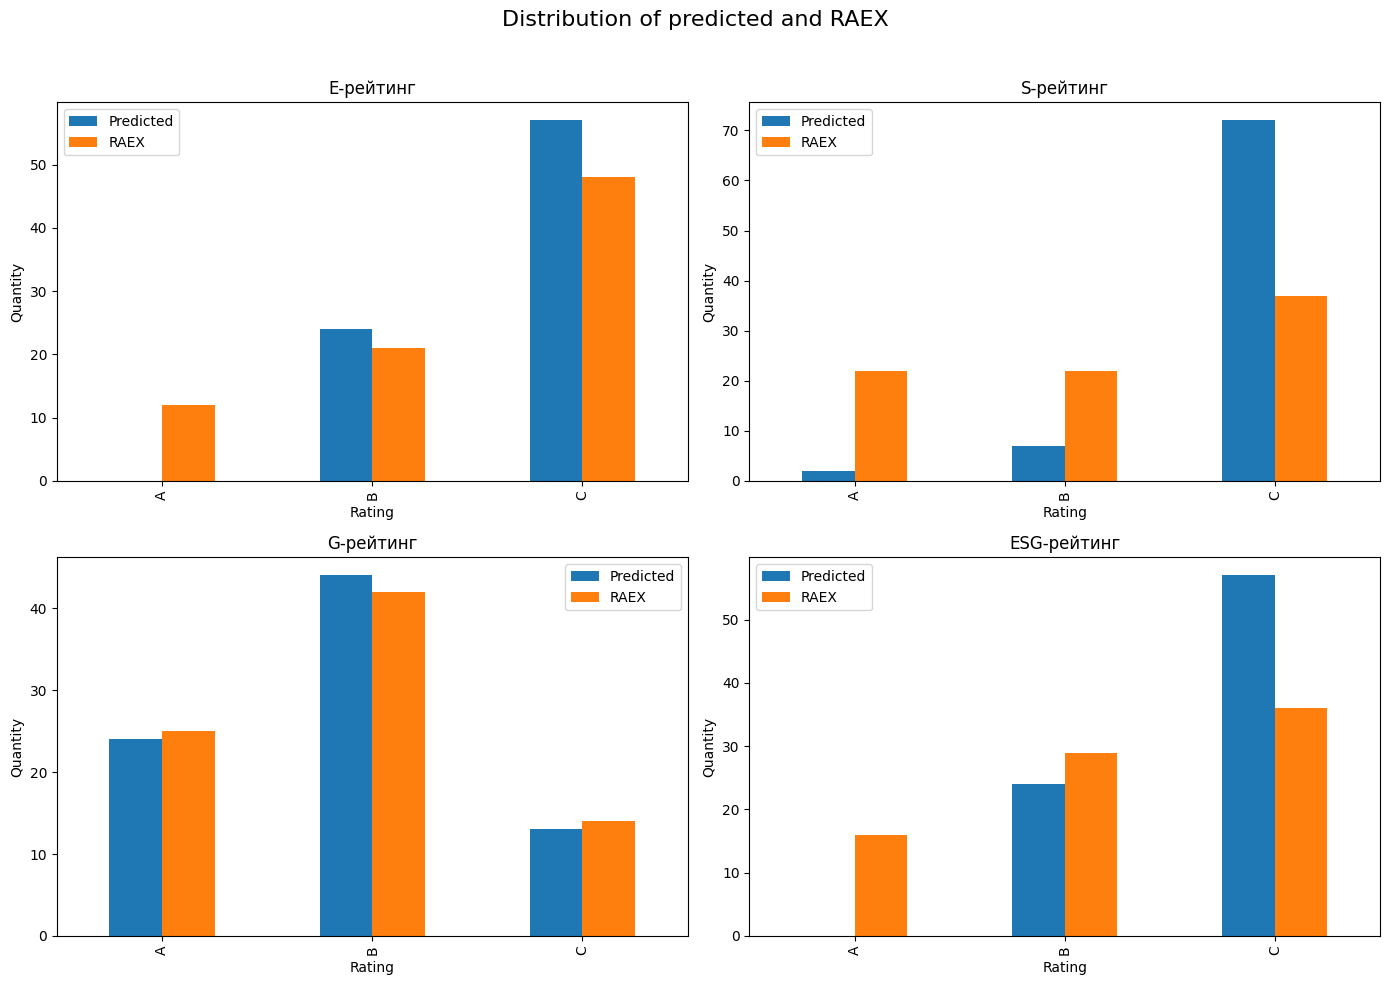

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of predicted and RAEX', fontsize=16)

ratings = ['E-рейтинг', 'S-рейтинг', 'G-рейтинг', 'ESG-рейтинг']

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    df_pred = df[rating].value_counts().sort_index()
    df_true = df[f"{rating} RAEX"].value_counts().sort_index()
    df_compare = pd.DataFrame({'Predicted': df_pred, 'RAEX': df_true})
    df_compare.plot(kind='bar', ax=ax_i)
    ax_i.set_title(rating)
    ax_i.set_xlabel('Rating')
    ax_i.set_ylabel('Quantity')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

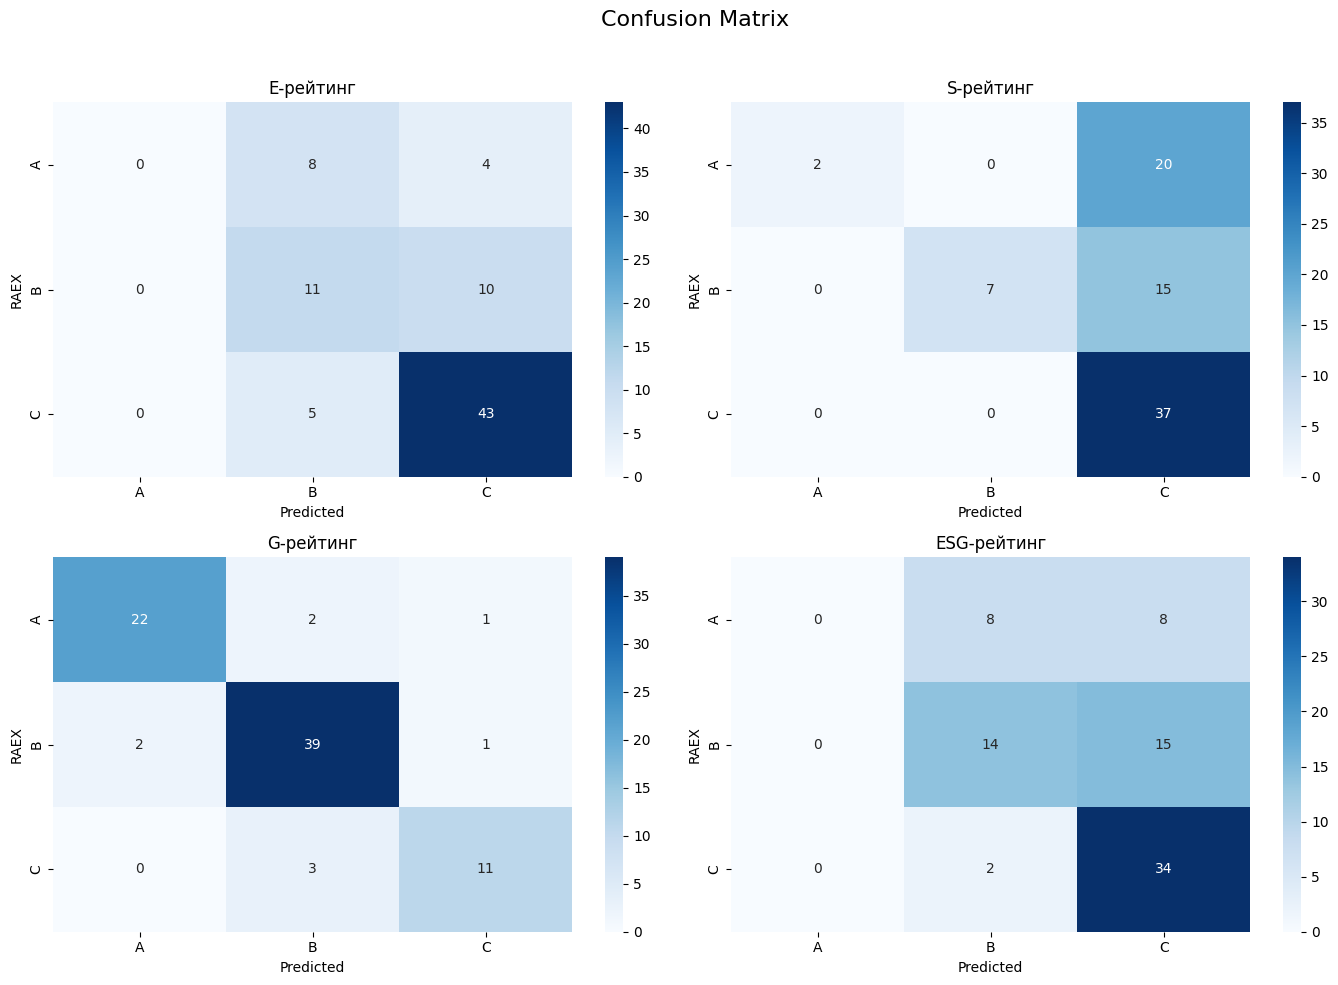

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrix', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    cm = confusion_matrix(df[f"{rating} RAEX"], df[rating], labels=['A', 'B', 'C'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'], ax=ax_i, cmap='Blues')
    ax_i.set_title(rating)
    ax_i.set_xlabel('Predicted')
    ax_i.set_ylabel('RAEX')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

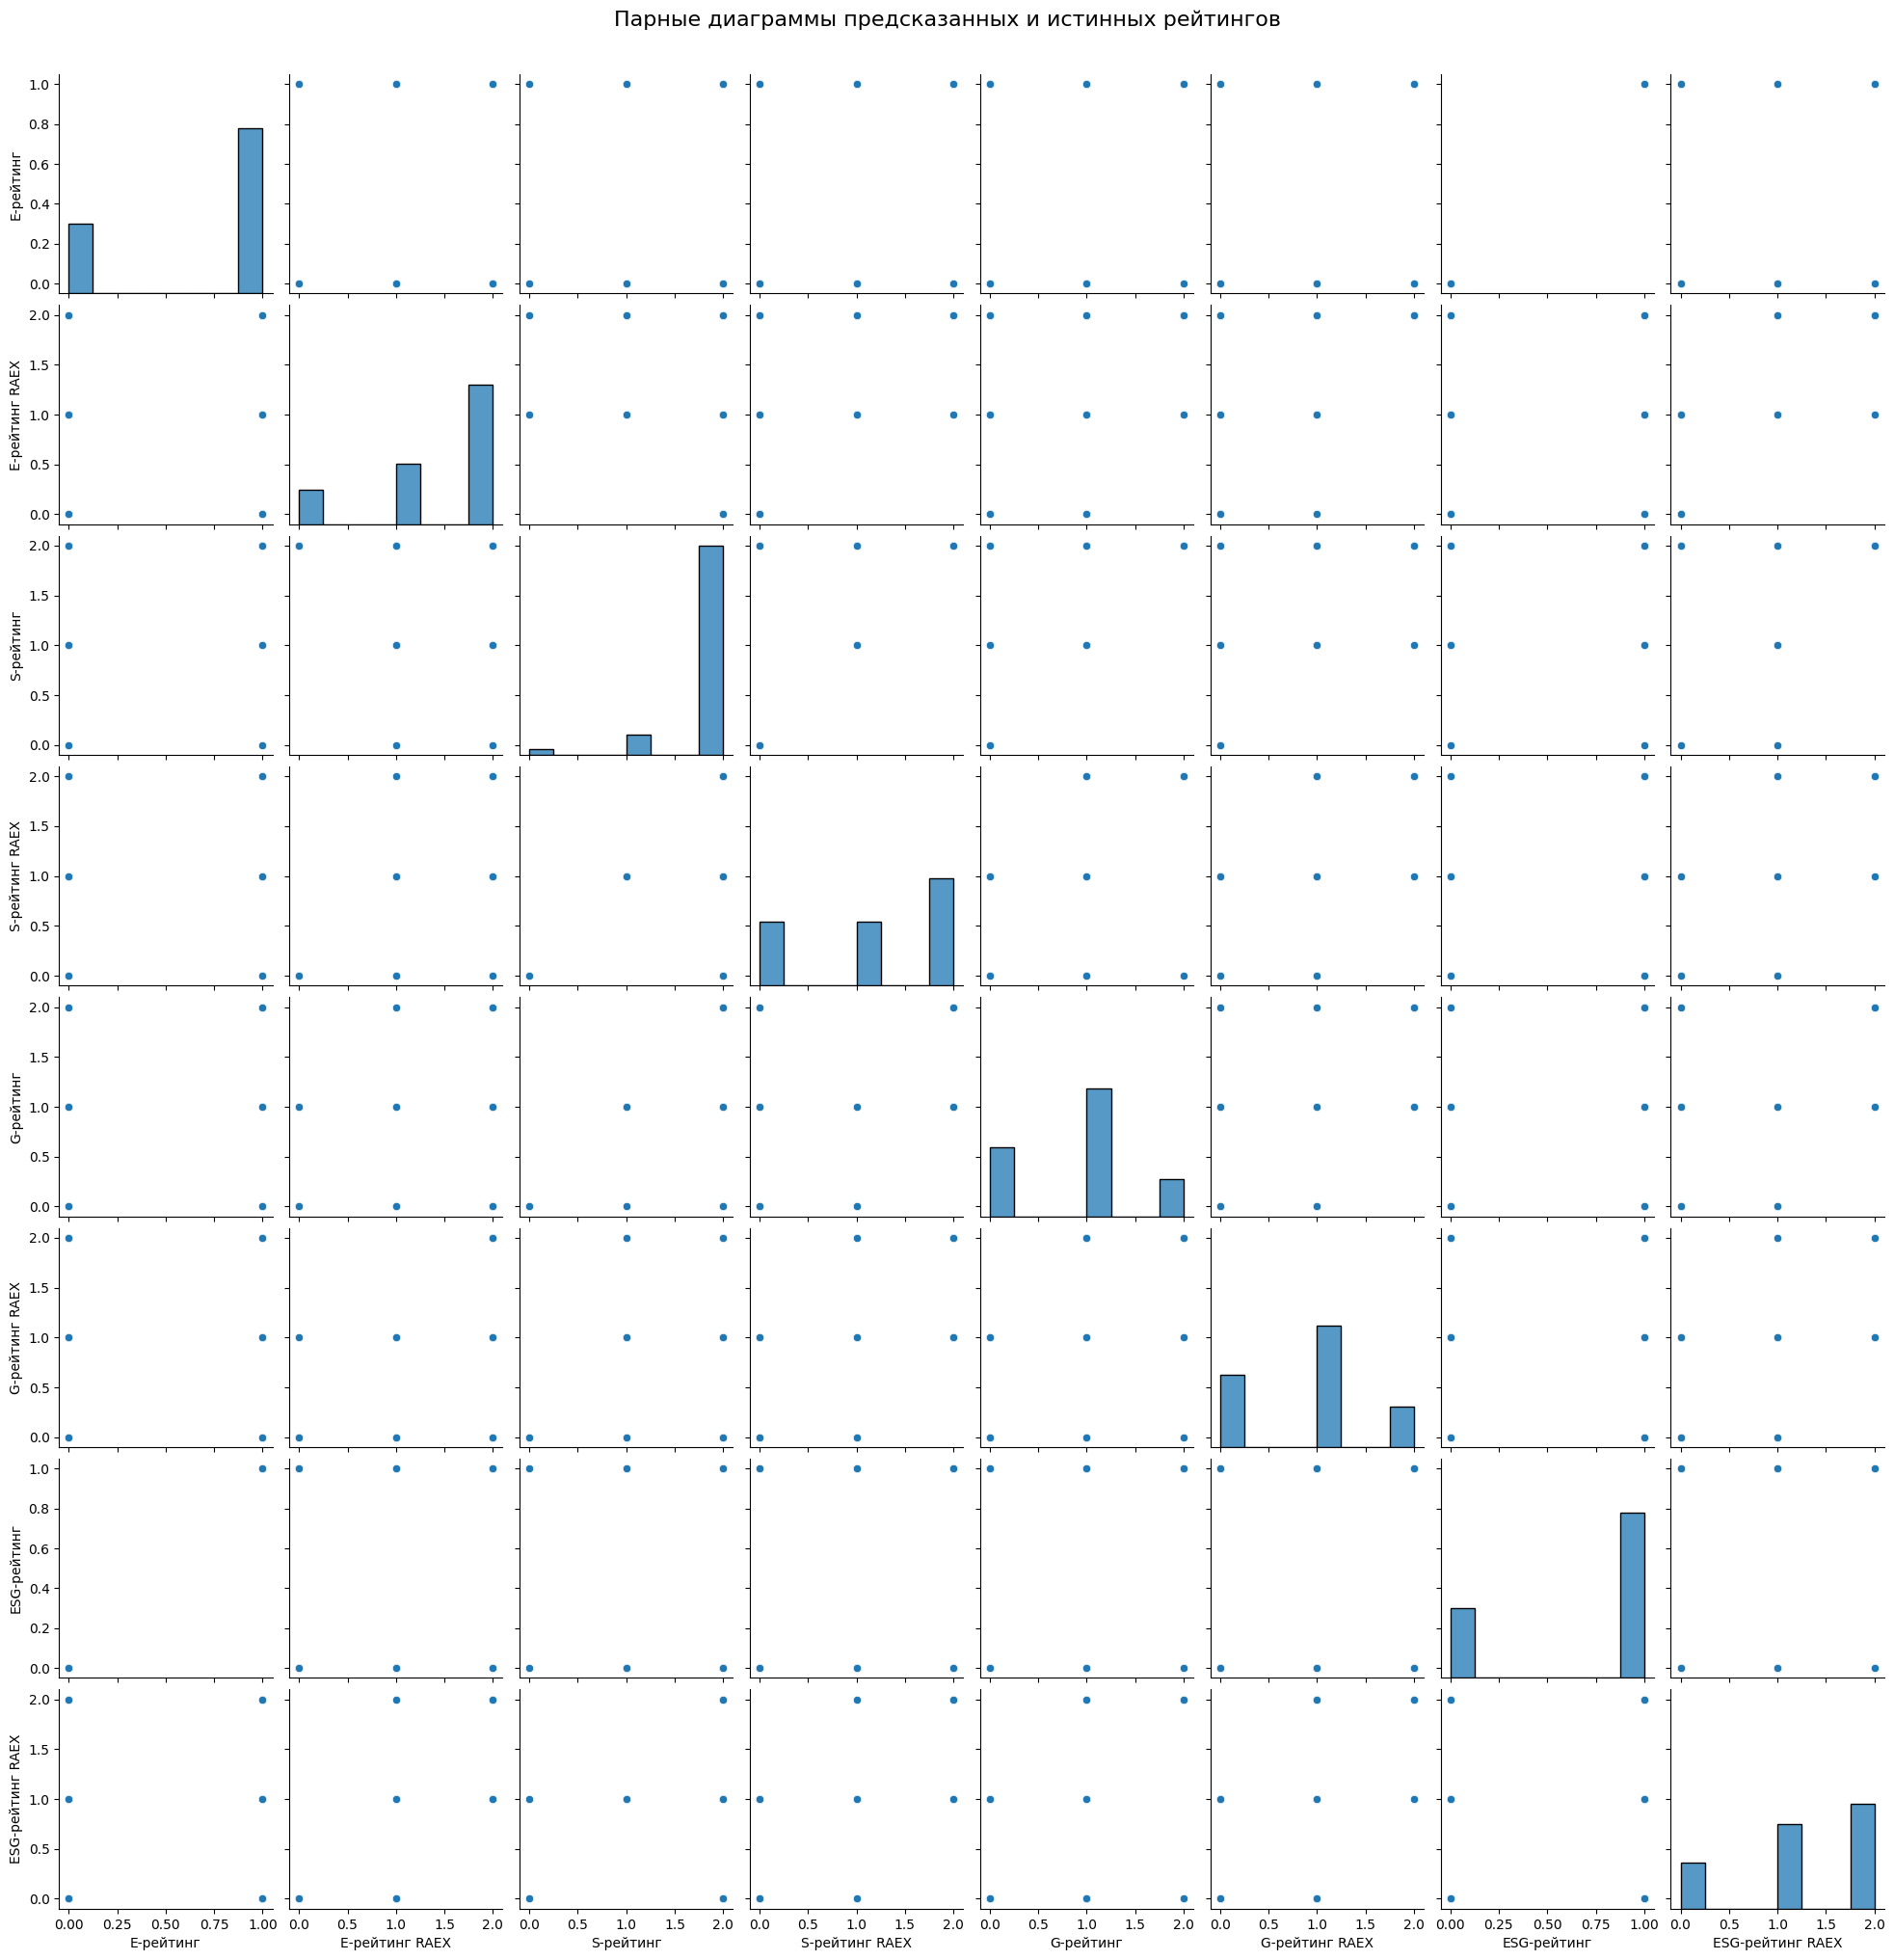

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Преобразование категориальных данных в числовые для pairplot
df_encoded = df.apply(lambda x: x.astype('category').cat.codes)

# Подготовка данных для парной диаграммы
pairplot_data = df_encoded[['E-рейтинг', 'E-рейтинг RAEX', 'S-рейтинг', 'S-рейтинг RAEX', 'G-рейтинг', 'G-рейтинг RAEX', 'ESG-рейтинг', 'ESG-рейтинг RAEX']]

# Создание парной диаграммы
sns.pairplot(pairplot_data)
plt.suptitle('Парные диаграммы предсказанных и истинных рейтингов', y=1.02, fontsize=16)
plt.show()

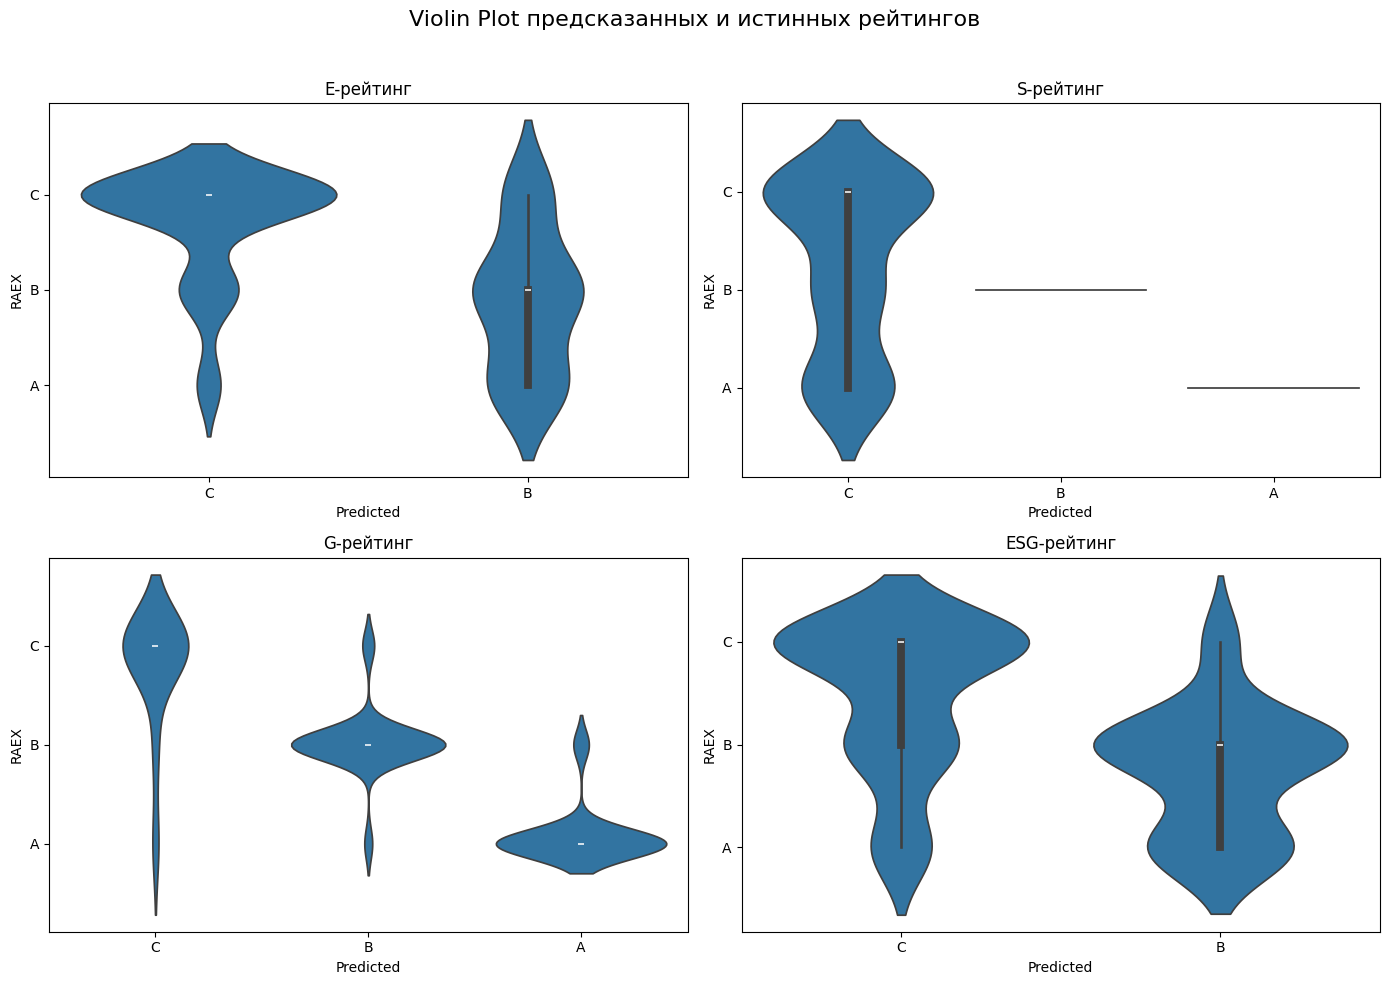

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Violin Plot предсказанных и истинных рейтингов', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    sns.violinplot(x=df[rating], y=df[f"{rating} RAEX"], ax=ax_i)
    ax_i.set_title(rating)
    ax_i.set_xlabel('Predicted')
    ax_i.set_ylabel('RAEX')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

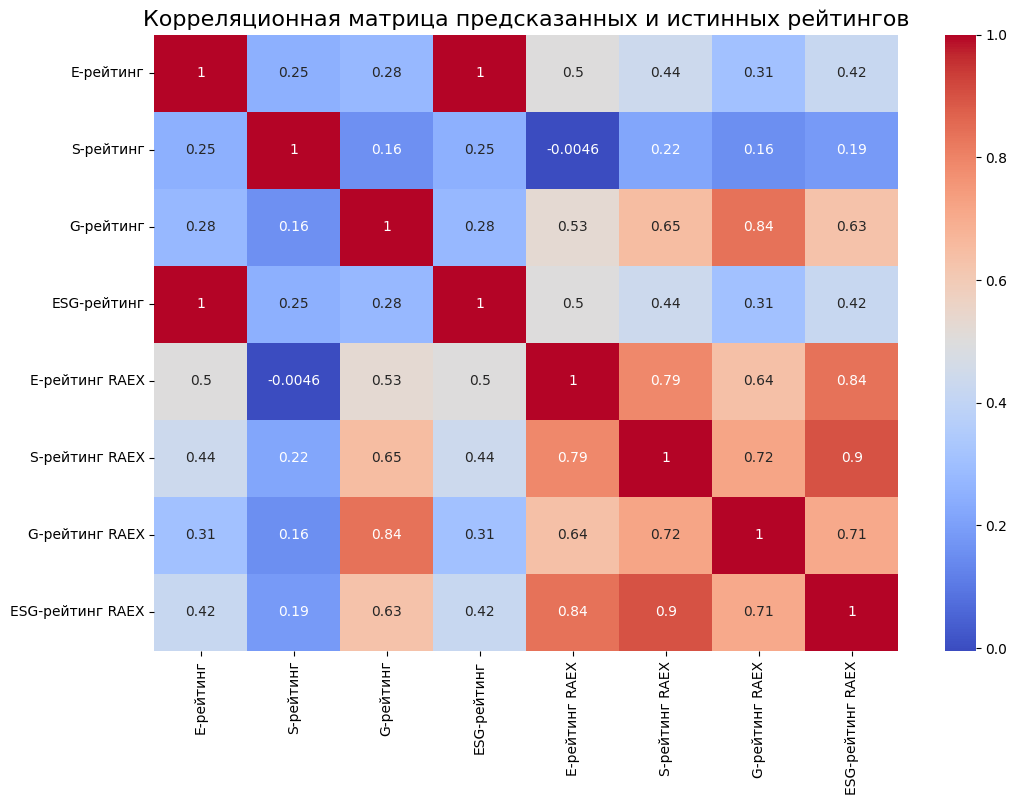

In [ ]:
# Преобразование категориальных данных в числовые для корреляции
df_encoded = df.apply(lambda x: x.astype('category').cat.codes)

# Расчет корреляционной матрицы
corr = df_encoded.corr()

# Построение тепловой карты корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Корреляционная матрица предсказанных и истинных рейтингов', fontsize=16)
plt.show()

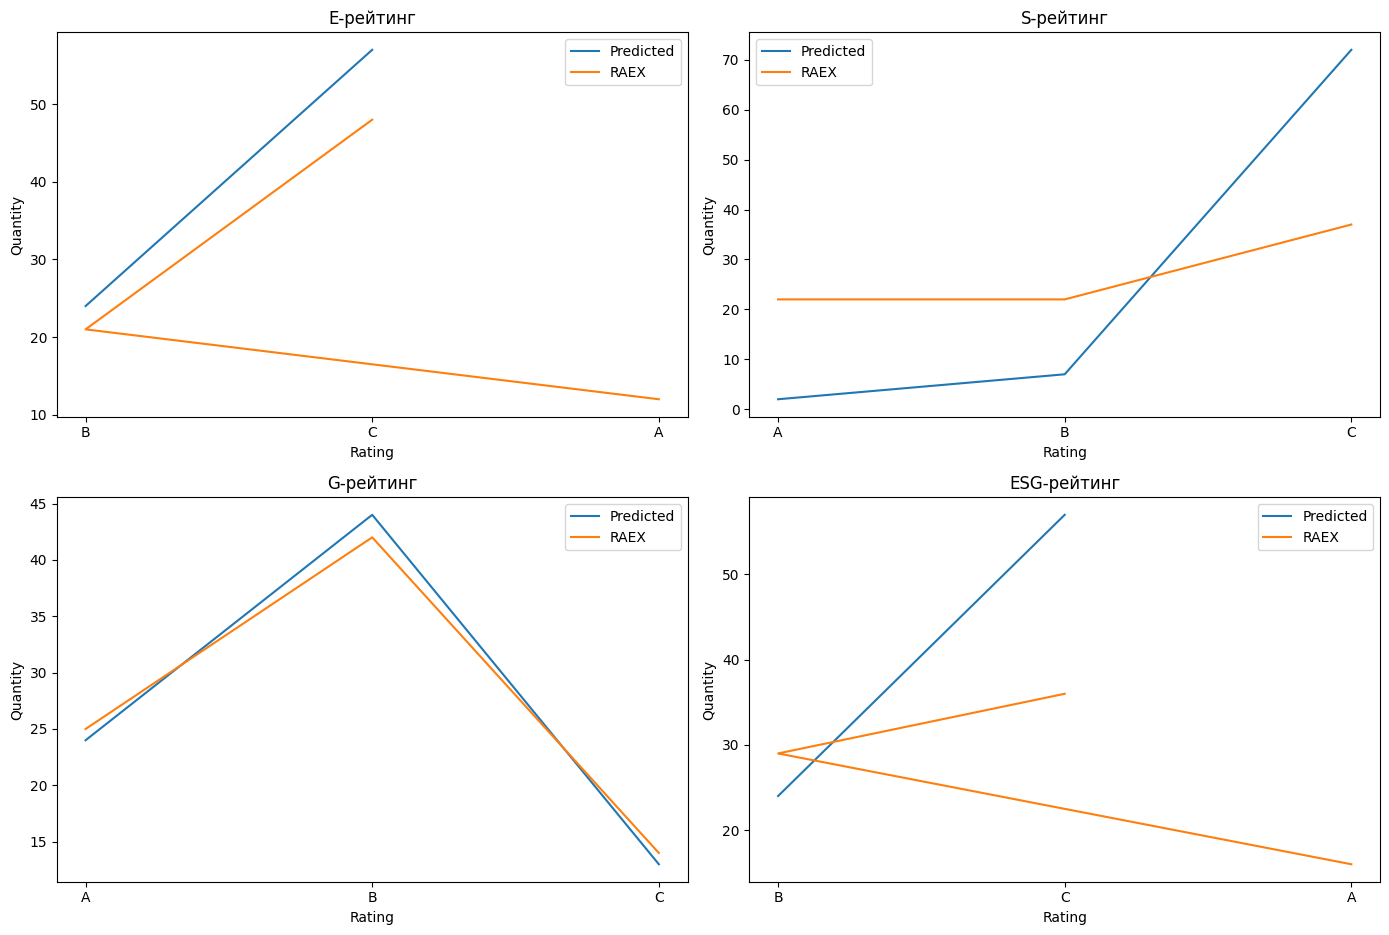

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    df_pred = df[rating].value_counts().sort_index()
    df_true = df[f"{rating} RAEX"].value_counts().sort_index()
    ax_i.plot(df_pred.index, df_pred.values, label='Predicted')
    ax_i.plot(df_true.index, df_true.values, label='RAEX')
    ax_i.set_title(rating)
    ax_i.set_xlabel('Rating')
    ax_i.set_ylabel('Quantity')
    ax_i.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

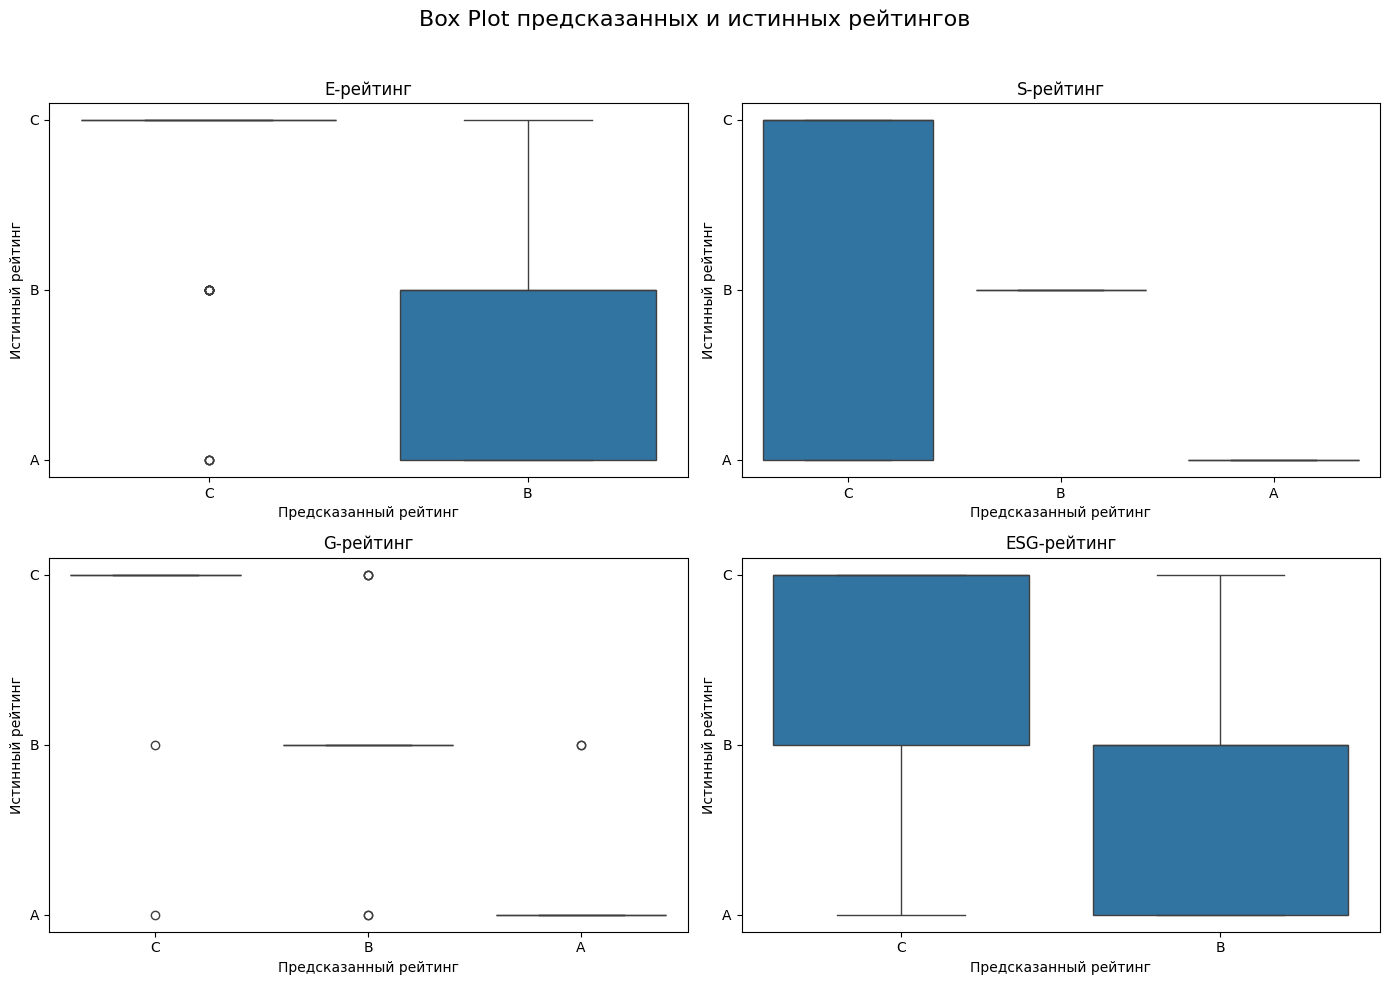

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Box Plot предсказанных и истинных рейтингов', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    sns.boxplot(x=df[rating], y=df[f"{rating} RAEX"], ax=ax_i)
    ax_i.set_title(rating)
    ax_i.set_xlabel('Предсказанный рейтинг')
    ax_i.set_ylabel('Истинный рейтинг')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

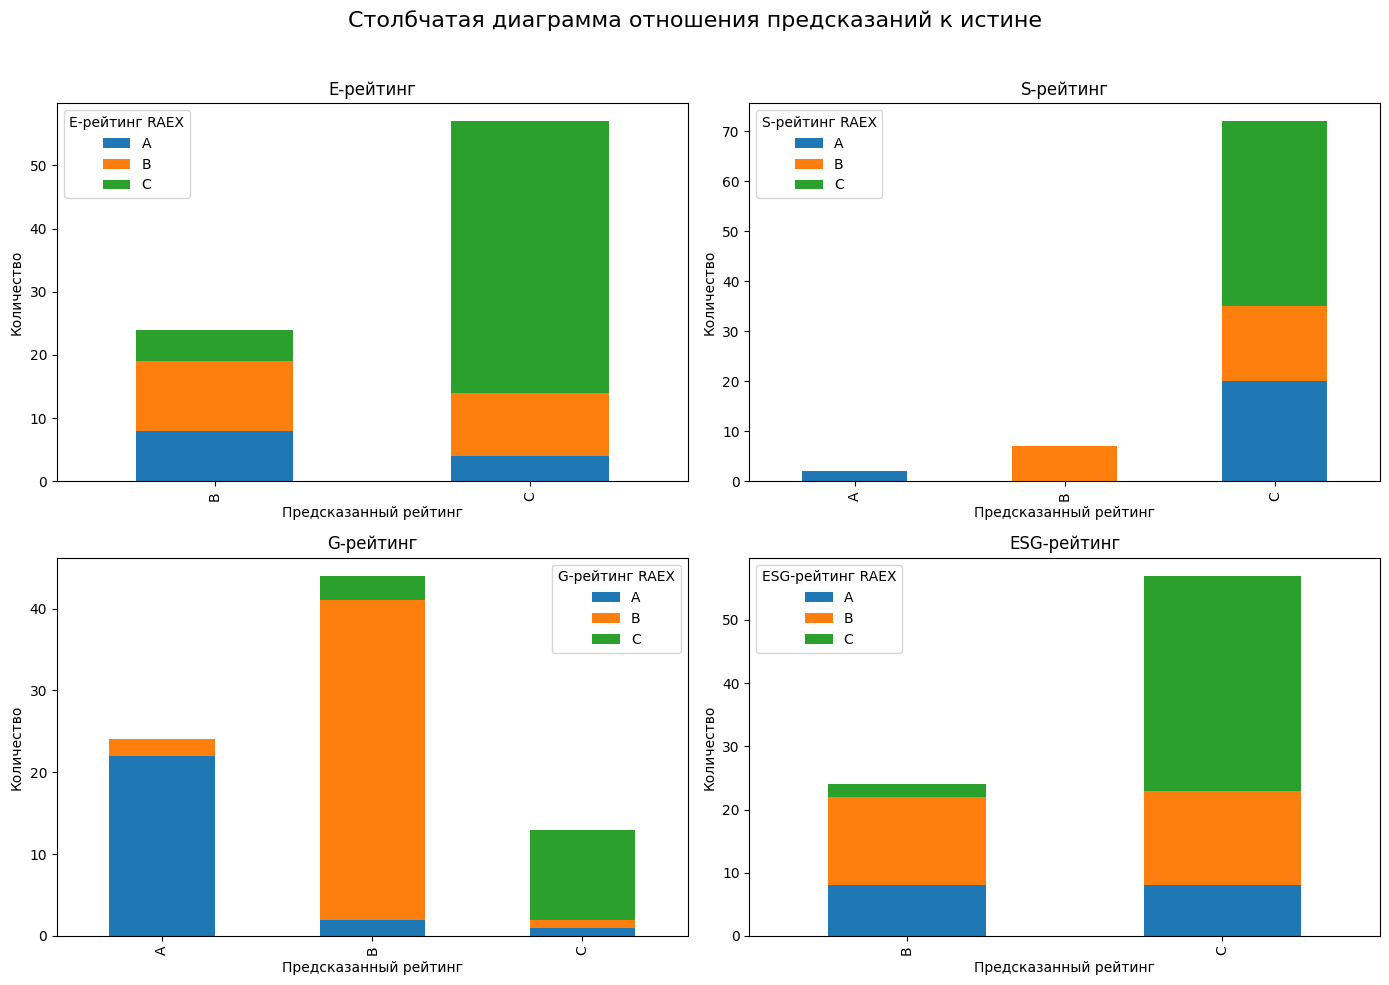

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Столбчатая диаграмма отношения предсказаний к истине', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    df_grouped = df.groupby([rating, f"{rating} RAEX"]).size().unstack().fillna(0)
    df_grouped.plot(kind='bar', stacked=True, ax=ax_i)
    ax_i.set_title(rating)
    ax_i.set_xlabel('Предсказанный рейтинг')
    ax_i.set_ylabel('Количество')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

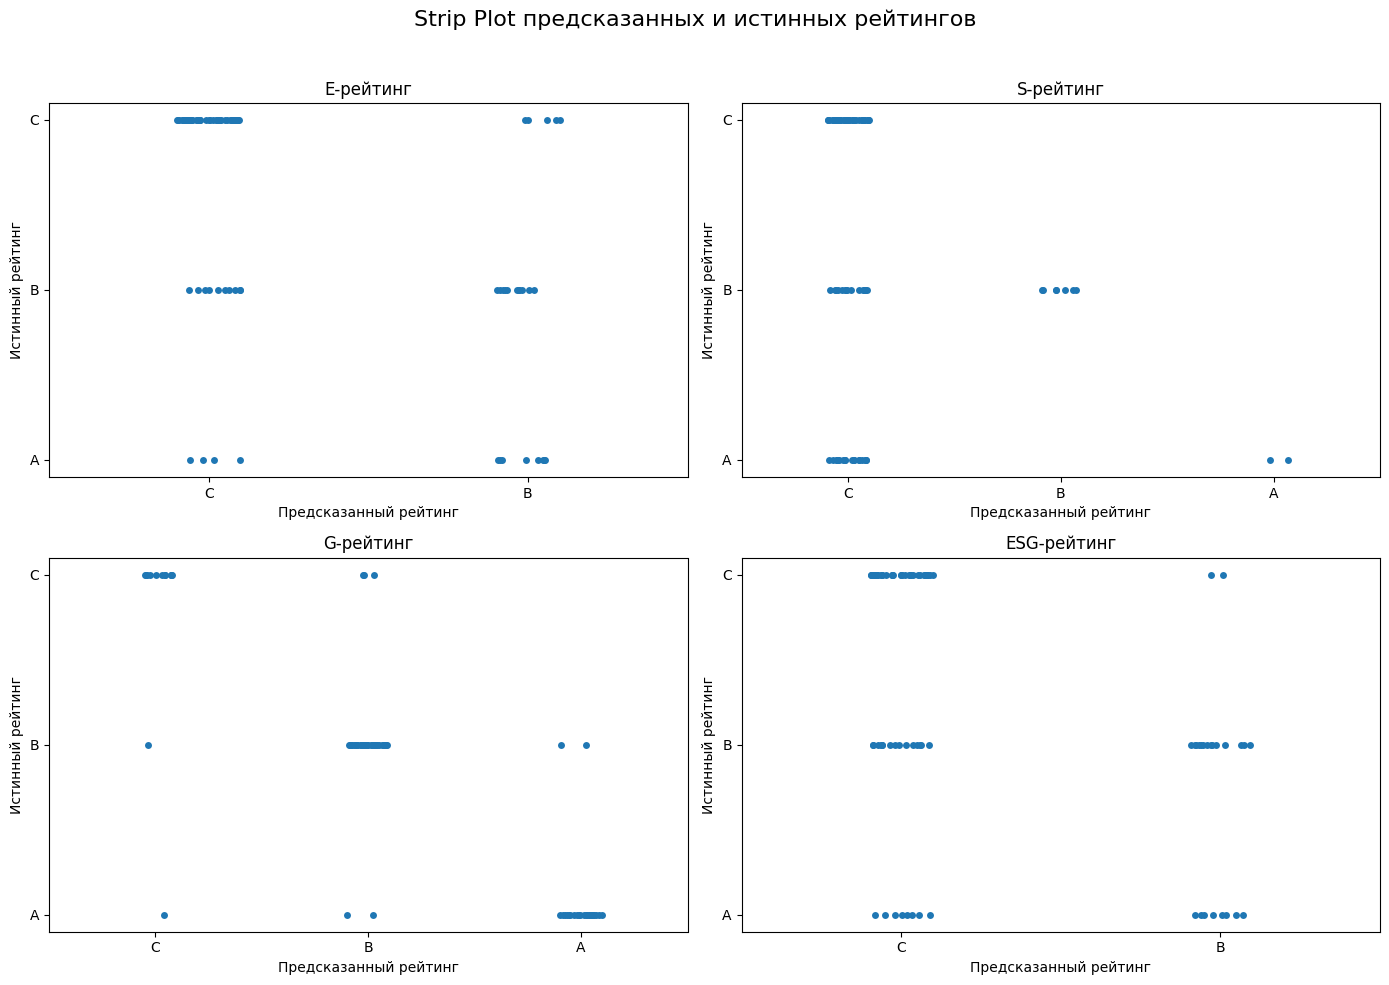

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Strip Plot предсказанных и истинных рейтингов', fontsize=16)

for i, rating in enumerate(ratings):
    ax_i = ax[i // 2, i % 2]
    sns.stripplot(x=df[rating], y=df[f"{rating} RAEX"], ax=ax_i, jitter=True)
    ax_i.set_title(rating)
    ax_i.set_xlabel('Предсказанный рейтинг')
    ax_i.set_ylabel('Истинный рейтинг')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()